# E12

In [154]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf

import keras
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn
seaborn.set(style='white')
seaborn.set_context('paper')

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




## Environment Setting

In [192]:
BASE_PATH = os.path.join(os.getenv('HOME'), 'aiffel/sia_gis/Hackerton')   # project folder
DATA_PATH = os.path.join(BASE_PATH, 'RSI_OP_NIA_AIHUB')                   # data folder
FILE_PATH = DATA_PATH + '/LV1_PNG_DATASET_for_AREA_B.h5'
SAVE_MODEL_PATH = DATA_PATH + '/trained_models'

BASE_TARIN_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
# 추가 그룹
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'      
TRAIN_FILTER_DIR = f'{Path(BASE_TARIN_DIR)}/filtered'  
TRAIN_FILTER_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/filtered/img'           
TRAIN_FILTER_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/filtered/label' 
TRAIN_CROP_FILTER_DIR = f'{Path(BASE_TARIN_DIR)}/crop_filtered'  
TRAIN_CROP_FILTER_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/crop_filtered/img'           
TRAIN_CROP_FILTER_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/crop_filtered/label'

BASE_VAL_DIR = "/valid"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
# 추가 그룹 및 데이터셋
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  
VAL_FILTER_DIR = f'{Path(BASE_VAL_DIR)}/filtered'  
VAL_FILTER_IMG_PATH = f'{Path(BASE_VAL_DIR)}/filtered/img'           
VAL_FILTER_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/filtered/label' 
VAL_CROP_FILTER_DIR = f'{Path(BASE_VAL_DIR)}/crop_filtered'  
VAL_CROP_FILTER_IMG_PATH = f'{Path(BASE_VAL_DIR)}/crop_filtered/img'           
VAL_CROP_FILTER_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/crop_filtered/label' 

BASE_TEST_DIR = "/test"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'
# 추가 그룹 및 데이터셋
TEST_SPLIT_DIR = f'{Path(BASE_TEST_DIR)}/split'  
TEST_SPLIT_IMG_PATH = f'{Path(BASE_TEST_DIR)}/split/img'           
TEST_SPLIT_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/split/label'  
TEST_FILTER_DIR = f'{Path(BASE_TEST_DIR)}/filtered'  
TEST_FILTER_IMG_PATH = f'{Path(BASE_TEST_DIR)}/filtered/img'           
TEST_FILTER_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/filtered/label' 
TEST_CROP_FILTER_DIR = f'{Path(BASE_TEST_DIR)}/crop_filtered'  
TEST_CROP_FILTER_IMG_PATH = f'{Path(BASE_TEST_DIR)}/crop_filtered/img'           
TEST_CROP_FILTER_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/crop_filtered/label' 

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

* building는 COLOR_MAP[0]
* road는 COLOR_MAP[1]

## dataset 확인

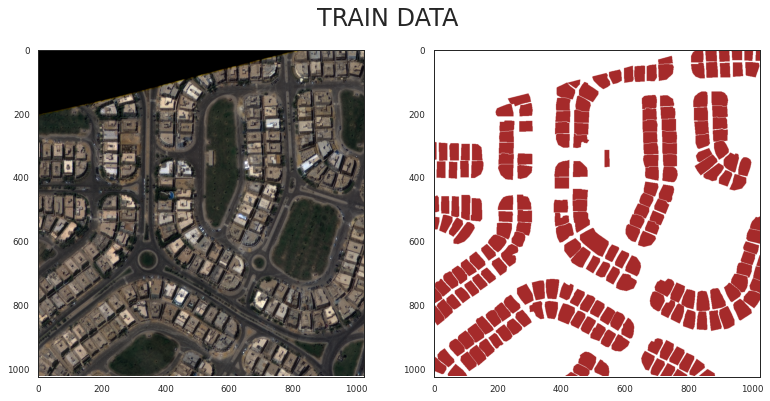

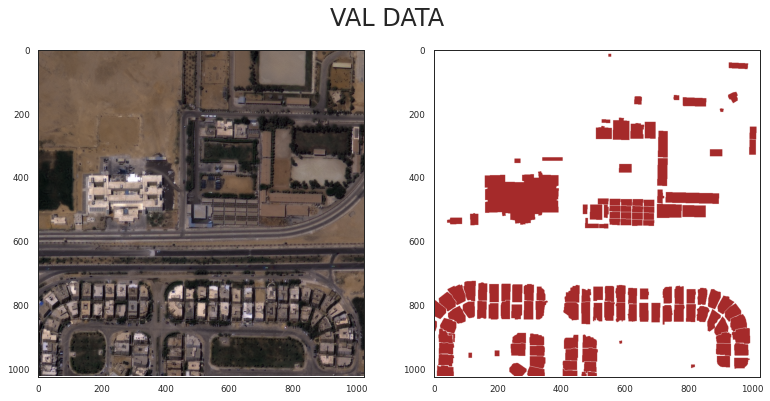

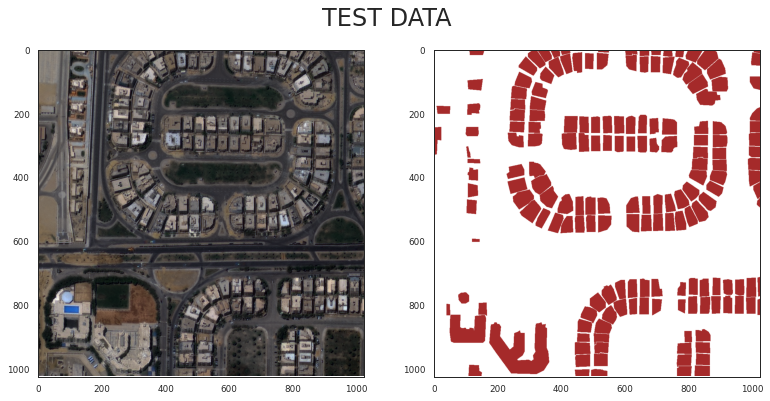

In [180]:
import matplotlib.pyplot as plt
i = 0

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.rc('figure', figsize=(13,6))
    plt.rc('font', size=20)

    
    plt.suptitle('TRAIN DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('VAL DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[VAL_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[VAL_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('TEST DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TEST_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TEST_LABEL_PATH][i])
    plt.show()

##  빌딩 라벨 분율이 설정값 이상인 경우 저장

In [83]:
LIMIT_AREA_PERCENT = 5

### train

In [86]:
with h5py.File(FILE_PATH, "a") as f:
    train_size = f[TRAIN_IMG_PATH].shape[0]
    if 'filtered' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_FILTER_DIR]
    f[BASE_TARIN_DIR].create_group('filtered')
    f[BASE_TARIN_DIR]['filtered'].create_dataset('img', (train_size, 1024, 1024, 3), np.uint8)
    f[BASE_TARIN_DIR]['filtered'].create_dataset('label', (train_size, 1024, 1024), np.float32)
    
    cnt = 0
    train_dic = {}
    for i in tqdm(range(f[TRAIN_IMG_PATH].shape[0])):
        img = f[TRAIN_IMG_PATH][i]
        mask = (f[TRAIN_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        total = 1024*1024
        building_area = mask.sum()
        area_pct = (building_area / total)*100
        print(f'Index: {i},  Area: {area_pct:.2f} %')
        train_dic[f'{i:04d}'] = float(f'{area_pct:.2f}')
        
        if area_pct >= LIMIT_AREA_PERCENT:
            f[TRAIN_FILTER_DIR]['img'][i, ...] = img
            f[TRAIN_FILTER_DIR]['label'][i, ...] = mask
            cnt +=1
    print(cnt)

  1%|          | 10/1088 [00:00<00:23, 46.56it/s]

Index: 0,  Area: 33.53 %
Index: 1,  Area: 34.41 %
Index: 2,  Area: 16.84 %
Index: 3,  Area: 34.45 %
Index: 4,  Area: 2.94 %
Index: 5,  Area: 6.55 %
Index: 6,  Area: 33.50 %
Index: 7,  Area: 39.18 %
Index: 8,  Area: 56.41 %
Index: 9,  Area: 0.09 %


  2%|▏         | 20/1088 [00:00<00:22, 46.74it/s]

Index: 10,  Area: 9.17 %
Index: 11,  Area: 30.26 %
Index: 12,  Area: 30.81 %
Index: 13,  Area: 14.05 %
Index: 14,  Area: 21.15 %
Index: 15,  Area: 18.19 %
Index: 16,  Area: 0.97 %
Index: 17,  Area: 24.30 %
Index: 18,  Area: 21.06 %
Index: 19,  Area: 21.43 %


  2%|▏         | 26/1088 [00:00<00:21, 48.52it/s]

Index: 20,  Area: 31.99 %
Index: 21,  Area: 40.75 %
Index: 22,  Area: 28.19 %
Index: 23,  Area: 0.29 %
Index: 24,  Area: 1.10 %
Index: 25,  Area: 20.91 %
Index: 26,  Area: 1.46 %
Index: 27,  Area: 33.46 %
Index: 28,  Area: 35.35 %
Index: 29,  Area: 0.96 %
Index: 30,  Area: 23.59 %


  3%|▎         | 37/1088 [00:00<00:22, 47.72it/s]

Index: 31,  Area: 33.14 %
Index: 32,  Area: 36.51 %
Index: 33,  Area: 38.72 %
Index: 34,  Area: 27.12 %
Index: 35,  Area: 25.94 %
Index: 36,  Area: 42.41 %
Index: 37,  Area: 31.49 %
Index: 38,  Area: 47.76 %
Index: 39,  Area: 26.96 %
Index: 40,  Area: 32.55 %


  4%|▍         | 47/1088 [00:00<00:22, 47.02it/s]

Index: 41,  Area: 5.35 %
Index: 42,  Area: 3.53 %
Index: 43,  Area: 5.59 %
Index: 44,  Area: 27.20 %
Index: 45,  Area: 43.36 %
Index: 46,  Area: 38.01 %
Index: 47,  Area: 23.54 %
Index: 48,  Area: 17.85 %
Index: 49,  Area: 9.15 %
Index: 50,  Area: 0.96 %


  5%|▌         | 58/1088 [00:01<00:21, 47.79it/s]

Index: 51,  Area: 1.25 %
Index: 52,  Area: 36.88 %
Index: 53,  Area: 10.00 %
Index: 54,  Area: 0.67 %
Index: 55,  Area: 0.02 %
Index: 56,  Area: 39.26 %
Index: 57,  Area: 19.87 %
Index: 58,  Area: 6.42 %
Index: 59,  Area: 12.70 %
Index: 60,  Area: 17.73 %


  6%|▋         | 68/1088 [00:01<00:21, 48.05it/s]

Index: 61,  Area: 15.70 %
Index: 62,  Area: 4.01 %
Index: 63,  Area: 15.25 %
Index: 64,  Area: 31.56 %
Index: 65,  Area: 7.84 %
Index: 66,  Area: 37.01 %
Index: 67,  Area: 3.57 %
Index: 68,  Area: 23.63 %
Index: 69,  Area: 25.66 %
Index: 70,  Area: 26.14 %


  7%|▋         | 79/1088 [00:01<00:20, 48.10it/s]

Index: 71,  Area: 16.43 %
Index: 72,  Area: 30.51 %
Index: 73,  Area: 25.59 %
Index: 74,  Area: 9.02 %
Index: 75,  Area: 7.47 %
Index: 76,  Area: 1.76 %
Index: 77,  Area: 1.65 %
Index: 78,  Area: 33.46 %
Index: 79,  Area: 12.85 %
Index: 80,  Area: 36.82 %


  8%|▊         | 89/1088 [00:01<00:21, 47.13it/s]

Index: 81,  Area: 28.96 %
Index: 82,  Area: 14.64 %
Index: 83,  Area: 8.09 %
Index: 84,  Area: 25.19 %
Index: 85,  Area: 0.11 %
Index: 86,  Area: 0.27 %
Index: 87,  Area: 20.77 %
Index: 88,  Area: 9.77 %
Index: 89,  Area: 8.61 %
Index: 90,  Area: 13.26 %


  9%|▉         | 99/1088 [00:02<00:21, 46.09it/s]

Index: 91,  Area: 11.35 %
Index: 92,  Area: 19.30 %
Index: 93,  Area: 5.32 %
Index: 94,  Area: 3.75 %
Index: 95,  Area: 0.80 %
Index: 96,  Area: 0.06 %
Index: 97,  Area: 0.18 %
Index: 98,  Area: 9.49 %
Index: 99,  Area: 0.06 %
Index: 100,  Area: 0.01 %
Index: 101,  Area: 0.11 %


 10%|█         | 111/1088 [00:02<00:19, 50.71it/s]

Index: 102,  Area: 5.33 %
Index: 103,  Area: 0.04 %
Index: 104,  Area: 0.15 %
Index: 105,  Area: 1.27 %
Index: 106,  Area: 0.06 %
Index: 107,  Area: 4.67 %
Index: 108,  Area: 4.38 %
Index: 109,  Area: 0.35 %
Index: 110,  Area: 3.08 %
Index: 111,  Area: 0.29 %
Index: 112,  Area: 0.16 %
Index: 113,  Area: 0.19 %


 11%|█▏        | 123/1088 [00:02<00:20, 48.11it/s]

Index: 114,  Area: 40.23 %
Index: 115,  Area: 59.46 %
Index: 116,  Area: 27.30 %
Index: 117,  Area: 69.84 %
Index: 118,  Area: 39.96 %
Index: 119,  Area: 51.35 %
Index: 120,  Area: 21.67 %
Index: 121,  Area: 14.54 %
Index: 122,  Area: 51.57 %


 12%|█▏        | 128/1088 [00:02<00:21, 44.20it/s]

Index: 123,  Area: 44.35 %
Index: 124,  Area: 75.66 %
Index: 125,  Area: 18.85 %
Index: 126,  Area: 16.76 %
Index: 127,  Area: 67.30 %
Index: 128,  Area: 63.45 %
Index: 129,  Area: 83.48 %
Index: 130,  Area: 26.35 %
Index: 131,  Area: 8.07 %


 13%|█▎        | 138/1088 [00:02<00:20, 45.48it/s]

Index: 132,  Area: 10.20 %
Index: 133,  Area: 16.69 %
Index: 134,  Area: 55.34 %
Index: 135,  Area: 44.59 %
Index: 136,  Area: 44.26 %
Index: 137,  Area: 12.83 %
Index: 138,  Area: 72.57 %
Index: 139,  Area: 11.81 %
Index: 140,  Area: 3.78 %
Index: 141,  Area: 29.48 %


 14%|█▎        | 148/1088 [00:03<00:20, 45.81it/s]

Index: 142,  Area: 46.37 %
Index: 143,  Area: 55.36 %
Index: 144,  Area: 4.88 %
Index: 145,  Area: 4.24 %
Index: 146,  Area: 12.23 %
Index: 147,  Area: 60.43 %
Index: 148,  Area: 60.83 %
Index: 149,  Area: 56.33 %
Index: 150,  Area: 66.05 %
Index: 151,  Area: 0.04 %


 15%|█▍        | 158/1088 [00:03<00:20, 44.98it/s]

Index: 152,  Area: 1.34 %
Index: 153,  Area: 33.36 %
Index: 154,  Area: 4.60 %
Index: 155,  Area: 32.72 %
Index: 156,  Area: 44.40 %
Index: 157,  Area: 7.84 %
Index: 158,  Area: 2.56 %
Index: 159,  Area: 17.78 %
Index: 160,  Area: 38.20 %
Index: 161,  Area: 42.29 %


 15%|█▌        | 168/1088 [00:03<00:19, 46.30it/s]

Index: 162,  Area: 25.22 %
Index: 163,  Area: 6.98 %
Index: 164,  Area: 11.12 %
Index: 165,  Area: 47.97 %
Index: 166,  Area: 38.83 %
Index: 167,  Area: 37.45 %
Index: 168,  Area: 0.03 %
Index: 169,  Area: 58.70 %
Index: 170,  Area: 53.07 %
Index: 171,  Area: 2.37 %


 16%|█▋        | 178/1088 [00:03<00:22, 41.03it/s]

Index: 172,  Area: 36.45 %
Index: 173,  Area: 17.84 %
Index: 174,  Area: 0.10 %
Index: 175,  Area: 43.36 %
Index: 176,  Area: 52.89 %
Index: 177,  Area: 46.83 %
Index: 178,  Area: 0.78 %
Index: 179,  Area: 0.35 %
Index: 180,  Area: 0.07 %


 17%|█▋        | 189/1088 [00:04<00:19, 45.00it/s]

Index: 181,  Area: 35.11 %
Index: 182,  Area: 28.10 %
Index: 183,  Area: 2.75 %
Index: 184,  Area: 7.74 %
Index: 185,  Area: 9.95 %
Index: 186,  Area: 13.91 %
Index: 187,  Area: 14.66 %
Index: 188,  Area: 1.48 %
Index: 189,  Area: 24.47 %
Index: 190,  Area: 26.43 %


 18%|█▊        | 199/1088 [00:04<00:20, 44.31it/s]

Index: 191,  Area: 50.10 %
Index: 192,  Area: 27.63 %
Index: 193,  Area: 21.28 %
Index: 194,  Area: 15.12 %
Index: 195,  Area: 21.90 %
Index: 196,  Area: 30.26 %
Index: 197,  Area: 24.86 %
Index: 198,  Area: 24.99 %
Index: 199,  Area: 10.99 %
Index: 200,  Area: 15.34 %


 19%|█▉        | 209/1088 [00:04<00:19, 45.45it/s]

Index: 201,  Area: 15.48 %
Index: 202,  Area: 3.79 %
Index: 203,  Area: 1.47 %
Index: 204,  Area: 1.70 %
Index: 205,  Area: 26.05 %
Index: 206,  Area: 29.57 %
Index: 207,  Area: 23.26 %
Index: 208,  Area: 26.11 %
Index: 209,  Area: 15.70 %
Index: 210,  Area: 47.68 %


 20%|██        | 219/1088 [00:04<00:19, 45.43it/s]

Index: 211,  Area: 0.02 %
Index: 212,  Area: 23.43 %
Index: 213,  Area: 10.06 %
Index: 214,  Area: 42.17 %
Index: 215,  Area: 36.55 %
Index: 216,  Area: 25.30 %
Index: 217,  Area: 15.14 %
Index: 218,  Area: 1.71 %
Index: 219,  Area: 34.36 %
Index: 220,  Area: 35.89 %


 21%|██        | 229/1088 [00:04<00:20, 42.38it/s]

Index: 221,  Area: 52.58 %
Index: 222,  Area: 31.14 %
Index: 223,  Area: 9.09 %
Index: 224,  Area: 27.68 %
Index: 225,  Area: 29.47 %
Index: 226,  Area: 54.00 %
Index: 227,  Area: 43.50 %
Index: 228,  Area: 33.61 %
Index: 229,  Area: 56.65 %


 22%|██▏       | 234/1088 [00:05<00:21, 40.51it/s]

Index: 230,  Area: 26.90 %
Index: 231,  Area: 8.32 %
Index: 232,  Area: 26.19 %
Index: 233,  Area: 35.16 %
Index: 234,  Area: 42.08 %
Index: 235,  Area: 31.20 %
Index: 236,  Area: 4.66 %
Index: 237,  Area: 15.32 %


 22%|██▏       | 243/1088 [00:05<00:21, 38.62it/s]

Index: 238,  Area: 16.33 %
Index: 239,  Area: 34.71 %
Index: 240,  Area: 41.03 %
Index: 241,  Area: 34.38 %
Index: 242,  Area: 45.26 %
Index: 243,  Area: 34.67 %
Index: 244,  Area: 6.19 %
Index: 245,  Area: 12.44 %
Index: 246,  Area: 19.36 %


 23%|██▎       | 253/1088 [00:05<00:19, 43.09it/s]

Index: 247,  Area: 21.83 %
Index: 248,  Area: 47.29 %
Index: 249,  Area: 35.73 %
Index: 250,  Area: 23.16 %
Index: 251,  Area: 4.31 %
Index: 252,  Area: 20.39 %
Index: 253,  Area: 10.76 %
Index: 254,  Area: 8.97 %
Index: 255,  Area: 38.31 %
Index: 256,  Area: 21.12 %


 25%|██▍       | 268/1088 [00:05<00:17, 46.38it/s]

Index: 257,  Area: 25.87 %
Index: 258,  Area: 22.13 %
Index: 259,  Area: 4.59 %
Index: 260,  Area: 7.09 %
Index: 261,  Area: 13.14 %
Index: 262,  Area: 13.10 %
Index: 263,  Area: 19.25 %
Index: 264,  Area: 23.81 %
Index: 265,  Area: 3.52 %
Index: 266,  Area: 10.96 %
Index: 267,  Area: 13.18 %


 26%|██▌       | 278/1088 [00:06<00:17, 46.46it/s]

Index: 268,  Area: 17.27 %
Index: 269,  Area: 0.09 %
Index: 270,  Area: 0.56 %
Index: 271,  Area: 11.84 %
Index: 272,  Area: 0.03 %
Index: 273,  Area: 26.34 %
Index: 274,  Area: 17.05 %
Index: 275,  Area: 1.11 %
Index: 276,  Area: 1.21 %
Index: 277,  Area: 15.07 %


 26%|██▌       | 283/1088 [00:06<00:18, 42.87it/s]

Index: 278,  Area: 31.04 %
Index: 279,  Area: 27.61 %
Index: 280,  Area: 30.57 %
Index: 281,  Area: 14.66 %
Index: 282,  Area: 16.82 %
Index: 283,  Area: 3.90 %
Index: 284,  Area: 3.54 %
Index: 285,  Area: 5.32 %
Index: 286,  Area: 16.78 %


 27%|██▋       | 293/1088 [00:06<00:17, 45.19it/s]

Index: 287,  Area: 34.35 %
Index: 288,  Area: 14.49 %
Index: 289,  Area: 45.43 %
Index: 290,  Area: 42.22 %
Index: 291,  Area: 32.18 %
Index: 292,  Area: 15.15 %
Index: 293,  Area: 27.26 %
Index: 294,  Area: 21.97 %
Index: 295,  Area: 11.53 %
Index: 296,  Area: 55.21 %


 28%|██▊       | 303/1088 [00:06<00:17, 45.64it/s]

Index: 297,  Area: 10.44 %
Index: 298,  Area: 6.77 %
Index: 299,  Area: 24.49 %
Index: 300,  Area: 28.00 %
Index: 301,  Area: 27.94 %
Index: 302,  Area: 47.63 %
Index: 303,  Area: 48.11 %
Index: 304,  Area: 46.83 %
Index: 305,  Area: 42.17 %
Index: 306,  Area: 36.28 %


 29%|██▉       | 313/1088 [00:06<00:16, 45.97it/s]

Index: 307,  Area: 27.96 %
Index: 308,  Area: 36.75 %
Index: 309,  Area: 46.03 %
Index: 310,  Area: 33.99 %
Index: 311,  Area: 49.48 %
Index: 312,  Area: 60.16 %
Index: 313,  Area: 32.46 %
Index: 314,  Area: 59.31 %
Index: 315,  Area: 50.13 %
Index: 316,  Area: 32.72 %


 30%|██▉       | 323/1088 [00:07<00:16, 46.43it/s]

Index: 317,  Area: 30.60 %
Index: 318,  Area: 28.85 %
Index: 319,  Area: 43.52 %
Index: 320,  Area: 44.75 %
Index: 321,  Area: 37.41 %
Index: 322,  Area: 16.76 %
Index: 323,  Area: 41.79 %
Index: 324,  Area: 41.59 %
Index: 325,  Area: 30.44 %
Index: 326,  Area: 32.19 %


 31%|███       | 333/1088 [00:07<00:16, 46.11it/s]

Index: 327,  Area: 35.85 %
Index: 328,  Area: 26.78 %
Index: 329,  Area: 16.49 %
Index: 330,  Area: 13.51 %
Index: 331,  Area: 32.74 %
Index: 332,  Area: 2.29 %
Index: 333,  Area: 36.40 %
Index: 334,  Area: 33.99 %
Index: 335,  Area: 44.52 %


 32%|███▏      | 343/1088 [00:07<00:18, 39.57it/s]

Index: 336,  Area: 34.23 %
Index: 337,  Area: 30.32 %
Index: 338,  Area: 38.09 %
Index: 339,  Area: 43.37 %
Index: 340,  Area: 40.42 %
Index: 341,  Area: 23.61 %
Index: 342,  Area: 14.09 %
Index: 343,  Area: 37.78 %


 32%|███▏      | 353/1088 [00:07<00:17, 42.59it/s]

Index: 344,  Area: 41.08 %
Index: 345,  Area: 33.71 %
Index: 346,  Area: 28.59 %
Index: 347,  Area: 18.87 %
Index: 348,  Area: 20.30 %
Index: 349,  Area: 44.32 %
Index: 350,  Area: 46.13 %
Index: 351,  Area: 32.06 %
Index: 352,  Area: 36.08 %
Index: 353,  Area: 13.81 %


 33%|███▎      | 364/1088 [00:08<00:15, 45.44it/s]

Index: 354,  Area: 33.00 %
Index: 355,  Area: 37.56 %
Index: 356,  Area: 30.25 %
Index: 357,  Area: 16.92 %
Index: 358,  Area: 10.73 %
Index: 359,  Area: 4.90 %
Index: 360,  Area: 10.62 %
Index: 361,  Area: 1.89 %
Index: 362,  Area: 13.54 %
Index: 363,  Area: 18.60 %


 34%|███▍      | 374/1088 [00:08<00:15, 45.46it/s]

Index: 364,  Area: 20.91 %
Index: 365,  Area: 42.15 %
Index: 366,  Area: 31.04 %
Index: 367,  Area: 18.00 %
Index: 368,  Area: 28.65 %
Index: 369,  Area: 40.54 %
Index: 370,  Area: 22.23 %
Index: 371,  Area: 23.87 %
Index: 372,  Area: 22.44 %
Index: 373,  Area: 6.55 %


 35%|███▍      | 379/1088 [00:08<00:15, 46.62it/s]

Index: 374,  Area: 11.63 %
Index: 375,  Area: 28.25 %
Index: 376,  Area: 8.90 %
Index: 377,  Area: 21.43 %
Index: 378,  Area: 4.50 %
Index: 379,  Area: 8.09 %
Index: 380,  Area: 5.18 %
Index: 381,  Area: 21.69 %
Index: 382,  Area: 36.32 %


 36%|███▌      | 389/1088 [00:08<00:16, 41.13it/s]

Index: 383,  Area: 33.70 %
Index: 384,  Area: 5.03 %
Index: 385,  Area: 45.56 %
Index: 386,  Area: 11.66 %
Index: 387,  Area: 26.44 %
Index: 388,  Area: 27.53 %
Index: 389,  Area: 26.67 %
Index: 390,  Area: 22.17 %
Index: 391,  Area: 23.86 %


 37%|███▋      | 399/1088 [00:08<00:16, 42.60it/s]

Index: 392,  Area: 27.51 %
Index: 393,  Area: 30.74 %
Index: 394,  Area: 13.00 %
Index: 395,  Area: 28.13 %
Index: 396,  Area: 29.22 %
Index: 397,  Area: 7.64 %
Index: 398,  Area: 40.43 %
Index: 399,  Area: 36.78 %
Index: 400,  Area: 35.62 %


 38%|███▊      | 410/1088 [00:09<00:15, 44.61it/s]

Index: 401,  Area: 40.85 %
Index: 402,  Area: 35.57 %
Index: 403,  Area: 30.06 %
Index: 404,  Area: 1.98 %
Index: 405,  Area: 0.20 %
Index: 406,  Area: 3.49 %
Index: 407,  Area: 2.10 %
Index: 408,  Area: 2.98 %
Index: 409,  Area: 10.27 %
Index: 410,  Area: 0.50 %


 39%|███▊      | 421/1088 [00:09<00:14, 47.05it/s]

Index: 411,  Area: 3.63 %
Index: 412,  Area: 37.54 %
Index: 413,  Area: 32.78 %
Index: 414,  Area: 0.39 %
Index: 415,  Area: 34.38 %
Index: 416,  Area: 35.35 %
Index: 417,  Area: 38.59 %
Index: 418,  Area: 7.83 %
Index: 419,  Area: 0.74 %
Index: 420,  Area: 35.32 %
Index: 421,  Area: 34.97 %


 39%|███▉      | 427/1088 [00:09<00:13, 47.61it/s]

Index: 422,  Area: 3.90 %
Index: 423,  Area: 0.27 %
Index: 424,  Area: 3.42 %
Index: 425,  Area: 0.03 %
Index: 426,  Area: 14.67 %
Index: 427,  Area: 10.33 %
Index: 428,  Area: 4.20 %
Index: 429,  Area: 27.84 %
Index: 430,  Area: 1.12 %
Index: 431,  Area: 8.12 %


 40%|████      | 439/1088 [00:09<00:13, 48.68it/s]

Index: 432,  Area: 51.05 %
Index: 433,  Area: 41.56 %
Index: 434,  Area: 0.45 %
Index: 435,  Area: 1.35 %
Index: 436,  Area: 0.46 %
Index: 437,  Area: 3.80 %
Index: 438,  Area: 11.37 %
Index: 439,  Area: 14.26 %
Index: 440,  Area: 25.74 %
Index: 441,  Area: 28.05 %


 41%|████▏     | 449/1088 [00:09<00:14, 43.09it/s]

Index: 442,  Area: 24.34 %
Index: 443,  Area: 4.61 %
Index: 444,  Area: 28.77 %
Index: 445,  Area: 20.36 %
Index: 446,  Area: 3.32 %
Index: 447,  Area: 42.33 %
Index: 448,  Area: 16.23 %
Index: 449,  Area: 6.33 %


 42%|████▏     | 460/1088 [00:10<00:13, 46.02it/s]

Index: 450,  Area: 7.86 %
Index: 451,  Area: 24.11 %
Index: 452,  Area: 6.29 %
Index: 453,  Area: 14.38 %
Index: 454,  Area: 37.32 %
Index: 455,  Area: 0.36 %
Index: 456,  Area: 0.18 %
Index: 457,  Area: 18.87 %
Index: 458,  Area: 23.37 %
Index: 459,  Area: 27.12 %
Index: 460,  Area: 24.19 %


 43%|████▎     | 470/1088 [00:10<00:13, 47.11it/s]

Index: 461,  Area: 22.74 %
Index: 462,  Area: 9.24 %
Index: 463,  Area: 10.10 %
Index: 464,  Area: 1.36 %
Index: 465,  Area: 6.29 %
Index: 466,  Area: 49.57 %
Index: 467,  Area: 22.37 %
Index: 468,  Area: 17.37 %
Index: 469,  Area: 15.77 %
Index: 470,  Area: 7.18 %


 44%|████▍     | 480/1088 [00:10<00:12, 47.35it/s]

Index: 471,  Area: 8.92 %
Index: 472,  Area: 0.13 %
Index: 473,  Area: 0.47 %
Index: 474,  Area: 26.34 %
Index: 475,  Area: 17.59 %
Index: 476,  Area: 39.15 %
Index: 477,  Area: 42.83 %
Index: 478,  Area: 24.70 %
Index: 479,  Area: 34.53 %
Index: 480,  Area: 43.13 %
Index: 481,  Area: 23.66 %


 45%|████▌     | 490/1088 [00:10<00:12, 47.58it/s]

Index: 482,  Area: 29.20 %
Index: 483,  Area: 20.59 %
Index: 484,  Area: 44.94 %
Index: 485,  Area: 51.52 %
Index: 486,  Area: 36.99 %
Index: 487,  Area: 44.25 %
Index: 488,  Area: 0.21 %
Index: 489,  Area: 3.39 %
Index: 490,  Area: 19.21 %
Index: 491,  Area: 6.89 %


 46%|████▌     | 500/1088 [00:11<00:13, 42.36it/s]

Index: 492,  Area: 31.10 %
Index: 493,  Area: 17.78 %
Index: 494,  Area: 52.60 %
Index: 495,  Area: 35.37 %
Index: 496,  Area: 34.02 %
Index: 497,  Area: 57.41 %
Index: 498,  Area: 49.86 %
Index: 499,  Area: 44.31 %


 46%|████▋     | 505/1088 [00:11<00:14, 40.61it/s]

Index: 500,  Area: 0.11 %
Index: 501,  Area: 5.45 %
Index: 502,  Area: 0.06 %
Index: 503,  Area: 0.63 %
Index: 504,  Area: 24.42 %
Index: 505,  Area: 7.90 %
Index: 506,  Area: 4.95 %
Index: 507,  Area: 7.74 %


 47%|████▋     | 516/1088 [00:11<00:13, 43.16it/s]

Index: 508,  Area: 2.17 %
Index: 509,  Area: 8.08 %
Index: 510,  Area: 1.04 %
Index: 511,  Area: 0.06 %
Index: 512,  Area: 12.35 %
Index: 513,  Area: 3.47 %
Index: 514,  Area: 18.38 %
Index: 515,  Area: 24.73 %
Index: 516,  Area: 27.28 %
Index: 517,  Area: 7.76 %
Index: 518,  Area: 0.39 %


 48%|████▊     | 526/1088 [00:11<00:12, 43.69it/s]

Index: 519,  Area: 10.53 %
Index: 520,  Area: 13.46 %
Index: 521,  Area: 11.83 %
Index: 522,  Area: 7.86 %
Index: 523,  Area: 5.28 %
Index: 524,  Area: 8.79 %
Index: 525,  Area: 19.05 %
Index: 526,  Area: 0.86 %
Index: 527,  Area: 13.06 %
Index: 528,  Area: 8.35 %


 49%|████▉     | 536/1088 [00:11<00:12, 43.37it/s]

Index: 529,  Area: 5.67 %
Index: 530,  Area: 7.93 %
Index: 531,  Area: 19.03 %
Index: 532,  Area: 12.85 %
Index: 533,  Area: 12.92 %
Index: 534,  Area: 20.60 %
Index: 535,  Area: 24.42 %
Index: 536,  Area: 13.04 %
Index: 537,  Area: 3.89 %
Index: 538,  Area: 6.68 %


 50%|█████     | 546/1088 [00:12<00:11, 45.49it/s]

Index: 539,  Area: 10.79 %
Index: 540,  Area: 4.85 %
Index: 541,  Area: 7.40 %
Index: 542,  Area: 12.31 %
Index: 543,  Area: 10.50 %
Index: 544,  Area: 1.89 %
Index: 545,  Area: 3.68 %
Index: 546,  Area: 1.82 %
Index: 547,  Area: 0.17 %
Index: 548,  Area: 2.69 %
Index: 549,  Area: 10.99 %


 51%|█████     | 556/1088 [00:12<00:11, 46.93it/s]

Index: 550,  Area: 8.66 %
Index: 551,  Area: 0.04 %
Index: 552,  Area: 4.47 %
Index: 553,  Area: 10.08 %
Index: 554,  Area: 11.28 %
Index: 555,  Area: 16.58 %
Index: 556,  Area: 8.95 %
Index: 557,  Area: 2.84 %
Index: 558,  Area: 8.76 %
Index: 559,  Area: 4.81 %


 52%|█████▏    | 567/1088 [00:12<00:10, 48.88it/s]

Index: 560,  Area: 3.40 %
Index: 561,  Area: 0.40 %
Index: 562,  Area: 23.34 %
Index: 563,  Area: 3.32 %
Index: 564,  Area: 0.05 %
Index: 565,  Area: 0.37 %
Index: 566,  Area: 4.25 %
Index: 567,  Area: 4.82 %
Index: 568,  Area: 15.66 %
Index: 569,  Area: 5.42 %


 53%|█████▎    | 578/1088 [00:12<00:10, 48.86it/s]

Index: 570,  Area: 18.48 %
Index: 571,  Area: 7.39 %
Index: 572,  Area: 4.49 %
Index: 573,  Area: 0.12 %
Index: 574,  Area: 0.91 %
Index: 575,  Area: 10.77 %
Index: 576,  Area: 0.25 %
Index: 577,  Area: 0.90 %
Index: 578,  Area: 0.04 %
Index: 579,  Area: 0.02 %
Index: 580,  Area: 2.44 %


 54%|█████▍    | 590/1088 [00:12<00:09, 51.59it/s]

Index: 581,  Area: 0.83 %
Index: 582,  Area: 1.26 %
Index: 583,  Area: 2.84 %
Index: 584,  Area: 1.04 %
Index: 585,  Area: 1.32 %
Index: 586,  Area: 2.33 %
Index: 587,  Area: 0.19 %
Index: 588,  Area: 5.59 %
Index: 589,  Area: 3.49 %
Index: 590,  Area: 0.50 %
Index: 591,  Area: 0.43 %


 55%|█████▌    | 602/1088 [00:13<00:09, 52.28it/s]

Index: 592,  Area: 10.18 %
Index: 593,  Area: 0.23 %
Index: 594,  Area: 0.07 %
Index: 595,  Area: 0.75 %
Index: 596,  Area: 2.59 %
Index: 597,  Area: 11.53 %
Index: 598,  Area: 8.62 %
Index: 599,  Area: 6.49 %
Index: 600,  Area: 0.07 %
Index: 601,  Area: 0.22 %
Index: 602,  Area: 8.57 %


 56%|█████▋    | 614/1088 [00:13<00:09, 51.76it/s]

Index: 603,  Area: 25.47 %
Index: 604,  Area: 15.88 %
Index: 605,  Area: 2.02 %
Index: 606,  Area: 0.41 %
Index: 607,  Area: 2.61 %
Index: 608,  Area: 17.43 %
Index: 609,  Area: 1.15 %
Index: 610,  Area: 0.07 %
Index: 611,  Area: 0.03 %
Index: 612,  Area: 0.20 %
Index: 613,  Area: 1.67 %


 57%|█████▋    | 620/1088 [00:13<00:09, 51.34it/s]

Index: 614,  Area: 4.69 %
Index: 615,  Area: 0.41 %
Index: 616,  Area: 0.09 %
Index: 617,  Area: 0.38 %
Index: 618,  Area: 0.94 %
Index: 619,  Area: 4.42 %
Index: 620,  Area: 2.22 %
Index: 621,  Area: 0.06 %
Index: 622,  Area: 0.33 %
Index: 623,  Area: 14.04 %
Index: 624,  Area: 0.01 %


 58%|█████▊    | 632/1088 [00:13<00:08, 51.78it/s]

Index: 625,  Area: 0.40 %
Index: 626,  Area: 2.05 %
Index: 627,  Area: 8.59 %
Index: 628,  Area: 4.01 %
Index: 629,  Area: 4.57 %
Index: 630,  Area: 0.07 %
Index: 631,  Area: 7.18 %
Index: 632,  Area: 6.56 %
Index: 633,  Area: 1.91 %
Index: 634,  Area: 0.84 %
Index: 635,  Area: 0.21 %


 59%|█████▉    | 644/1088 [00:14<00:08, 52.21it/s]

Index: 636,  Area: 10.03 %
Index: 637,  Area: 0.63 %
Index: 638,  Area: 0.36 %
Index: 639,  Area: 0.25 %
Index: 640,  Area: 11.80 %
Index: 641,  Area: 0.57 %
Index: 642,  Area: 0.04 %
Index: 643,  Area: 15.38 %
Index: 644,  Area: 15.30 %
Index: 645,  Area: 0.08 %
Index: 646,  Area: 2.04 %


 60%|██████    | 656/1088 [00:14<00:08, 49.78it/s]

Index: 647,  Area: 0.34 %
Index: 648,  Area: 0.05 %
Index: 649,  Area: 0.02 %
Index: 650,  Area: 1.82 %
Index: 651,  Area: 3.55 %
Index: 652,  Area: 0.07 %
Index: 653,  Area: 0.11 %
Index: 654,  Area: 0.07 %
Index: 655,  Area: 5.89 %
Index: 656,  Area: 0.21 %
Index: 657,  Area: 1.63 %


 61%|██████▏   | 668/1088 [00:14<00:08, 50.43it/s]

Index: 658,  Area: 1.89 %
Index: 659,  Area: 0.27 %
Index: 660,  Area: 4.35 %
Index: 661,  Area: 0.74 %
Index: 662,  Area: 1.04 %
Index: 663,  Area: 9.39 %
Index: 664,  Area: 3.11 %
Index: 665,  Area: 0.08 %
Index: 666,  Area: 5.32 %
Index: 667,  Area: 0.01 %
Index: 668,  Area: 0.02 %


 62%|██████▎   | 680/1088 [00:14<00:08, 50.13it/s]

Index: 669,  Area: 0.21 %
Index: 670,  Area: 0.71 %
Index: 671,  Area: 4.15 %
Index: 672,  Area: 1.21 %
Index: 673,  Area: 16.31 %
Index: 674,  Area: 3.57 %
Index: 675,  Area: 1.70 %
Index: 676,  Area: 7.52 %
Index: 677,  Area: 2.09 %
Index: 678,  Area: 0.62 %
Index: 679,  Area: 2.31 %


 64%|██████▎   | 692/1088 [00:14<00:07, 52.64it/s]

Index: 680,  Area: 0.33 %
Index: 681,  Area: 0.40 %
Index: 682,  Area: 1.32 %
Index: 683,  Area: 7.08 %
Index: 684,  Area: 2.38 %
Index: 685,  Area: 0.15 %
Index: 686,  Area: 0.87 %
Index: 687,  Area: 0.15 %
Index: 688,  Area: 0.13 %
Index: 689,  Area: 0.57 %
Index: 690,  Area: 2.18 %
Index: 691,  Area: 7.01 %


 64%|██████▍   | 698/1088 [00:15<00:07, 51.48it/s]

Index: 692,  Area: 0.04 %
Index: 693,  Area: 0.29 %
Index: 694,  Area: 10.61 %
Index: 695,  Area: 20.02 %
Index: 696,  Area: 2.22 %
Index: 697,  Area: 0.24 %
Index: 698,  Area: 10.34 %
Index: 699,  Area: 0.42 %
Index: 700,  Area: 0.33 %
Index: 701,  Area: 0.12 %
Index: 702,  Area: 0.05 %


 65%|██████▌   | 710/1088 [00:15<00:07, 52.45it/s]

Index: 703,  Area: 0.04 %
Index: 704,  Area: 0.19 %
Index: 705,  Area: 3.88 %
Index: 706,  Area: 20.77 %
Index: 707,  Area: 0.22 %
Index: 708,  Area: 0.03 %
Index: 709,  Area: 9.28 %
Index: 710,  Area: 5.87 %
Index: 711,  Area: 1.94 %
Index: 712,  Area: 0.75 %
Index: 713,  Area: 0.21 %


 66%|██████▋   | 722/1088 [00:15<00:07, 51.81it/s]

Index: 714,  Area: 0.90 %
Index: 715,  Area: 7.08 %
Index: 716,  Area: 26.26 %
Index: 717,  Area: 4.88 %
Index: 718,  Area: 2.69 %
Index: 719,  Area: 15.60 %
Index: 720,  Area: 5.94 %
Index: 721,  Area: 1.58 %
Index: 722,  Area: 14.74 %
Index: 723,  Area: 1.31 %


 67%|██████▋   | 734/1088 [00:15<00:07, 49.86it/s]

Index: 724,  Area: 7.14 %
Index: 725,  Area: 0.72 %
Index: 726,  Area: 3.42 %
Index: 727,  Area: 1.13 %
Index: 728,  Area: 18.30 %
Index: 729,  Area: 0.30 %
Index: 730,  Area: 17.50 %
Index: 731,  Area: 19.90 %
Index: 732,  Area: 14.46 %
Index: 733,  Area: 0.74 %
Index: 734,  Area: 16.88 %


 68%|██████▊   | 739/1088 [00:15<00:07, 47.01it/s]

Index: 735,  Area: 11.98 %
Index: 736,  Area: 31.15 %
Index: 737,  Area: 9.39 %
Index: 738,  Area: 0.01 %
Index: 739,  Area: 36.74 %
Index: 740,  Area: 41.50 %
Index: 741,  Area: 6.36 %
Index: 742,  Area: 9.00 %


 69%|██████▉   | 749/1088 [00:16<00:07, 42.47it/s]

Index: 743,  Area: 24.13 %
Index: 744,  Area: 6.59 %
Index: 745,  Area: 7.07 %
Index: 746,  Area: 25.86 %
Index: 747,  Area: 10.97 %
Index: 748,  Area: 14.99 %
Index: 749,  Area: 41.58 %
Index: 750,  Area: 9.60 %
Index: 751,  Area: 15.69 %


 70%|██████▉   | 759/1088 [00:16<00:07, 44.76it/s]

Index: 752,  Area: 31.61 %
Index: 753,  Area: 28.26 %
Index: 754,  Area: 0.07 %
Index: 755,  Area: 14.45 %
Index: 756,  Area: 25.67 %
Index: 757,  Area: 22.37 %
Index: 758,  Area: 30.07 %
Index: 759,  Area: 13.50 %
Index: 760,  Area: 4.63 %
Index: 761,  Area: 1.15 %


 71%|███████   | 770/1088 [00:16<00:06, 46.37it/s]

Index: 762,  Area: 8.15 %
Index: 763,  Area: 6.11 %
Index: 764,  Area: 6.30 %
Index: 765,  Area: 7.73 %
Index: 766,  Area: 12.18 %
Index: 767,  Area: 21.75 %
Index: 768,  Area: 4.10 %
Index: 769,  Area: 16.03 %
Index: 770,  Area: 5.93 %
Index: 771,  Area: 13.17 %


 72%|███████▏  | 781/1088 [00:16<00:06, 47.11it/s]

Index: 772,  Area: 6.28 %
Index: 773,  Area: 3.62 %
Index: 774,  Area: 3.78 %
Index: 775,  Area: 10.23 %
Index: 776,  Area: 19.62 %
Index: 777,  Area: 21.07 %
Index: 778,  Area: 10.91 %
Index: 779,  Area: 26.93 %
Index: 780,  Area: 27.09 %
Index: 781,  Area: 30.55 %
Index: 782,  Area: 33.73 %


 73%|███████▎  | 791/1088 [00:17<00:06, 43.80it/s]

Index: 783,  Area: 38.50 %
Index: 784,  Area: 5.55 %
Index: 785,  Area: 5.46 %
Index: 786,  Area: 10.18 %
Index: 787,  Area: 1.41 %
Index: 788,  Area: 20.13 %
Index: 789,  Area: 31.09 %
Index: 790,  Area: 35.49 %
Index: 791,  Area: 31.25 %


 73%|███████▎  | 796/1088 [00:17<00:07, 41.15it/s]

Index: 792,  Area: 20.75 %
Index: 793,  Area: 27.25 %
Index: 794,  Area: 29.81 %
Index: 795,  Area: 32.29 %
Index: 796,  Area: 8.05 %
Index: 797,  Area: 24.86 %
Index: 798,  Area: 24.46 %
Index: 799,  Area: 24.66 %


 74%|███████▍  | 806/1088 [00:17<00:07, 40.16it/s]

Index: 800,  Area: 25.84 %
Index: 801,  Area: 30.22 %
Index: 802,  Area: 6.90 %
Index: 803,  Area: 27.19 %
Index: 804,  Area: 22.79 %
Index: 805,  Area: 4.51 %
Index: 806,  Area: 26.68 %
Index: 807,  Area: 19.50 %
Index: 808,  Area: 26.68 %
Index: 809,  Area: 26.11 %


 75%|███████▌  | 816/1088 [00:17<00:06, 43.47it/s]

Index: 810,  Area: 35.73 %
Index: 811,  Area: 28.17 %
Index: 812,  Area: 22.61 %
Index: 813,  Area: 46.97 %
Index: 814,  Area: 24.26 %
Index: 815,  Area: 33.73 %
Index: 816,  Area: 32.69 %
Index: 817,  Area: 26.58 %
Index: 818,  Area: 36.93 %
Index: 819,  Area: 18.54 %


 76%|███████▌  | 827/1088 [00:17<00:05, 46.65it/s]

Index: 820,  Area: 1.87 %
Index: 821,  Area: 12.06 %
Index: 822,  Area: 17.75 %
Index: 823,  Area: 1.71 %
Index: 824,  Area: 40.36 %
Index: 825,  Area: 36.87 %
Index: 826,  Area: 35.55 %
Index: 827,  Area: 40.04 %
Index: 828,  Area: 26.58 %
Index: 829,  Area: 9.92 %


 77%|███████▋  | 838/1088 [00:18<00:05, 48.02it/s]

Index: 830,  Area: 16.70 %
Index: 831,  Area: 14.05 %
Index: 832,  Area: 5.87 %
Index: 833,  Area: 4.51 %
Index: 834,  Area: 7.41 %
Index: 835,  Area: 0.29 %
Index: 836,  Area: 21.43 %
Index: 837,  Area: 24.24 %
Index: 838,  Area: 29.97 %
Index: 839,  Area: 35.90 %
Index: 840,  Area: 5.97 %


 78%|███████▊  | 848/1088 [00:18<00:05, 47.07it/s]

Index: 841,  Area: 8.09 %
Index: 842,  Area: 19.95 %
Index: 843,  Area: 29.32 %
Index: 844,  Area: 35.49 %
Index: 845,  Area: 26.61 %
Index: 846,  Area: 12.00 %
Index: 847,  Area: 27.38 %
Index: 848,  Area: 14.32 %
Index: 849,  Area: 7.09 %
Index: 850,  Area: 31.01 %


 79%|███████▉  | 858/1088 [00:18<00:04, 46.58it/s]

Index: 851,  Area: 30.15 %
Index: 852,  Area: 24.81 %
Index: 853,  Area: 21.24 %
Index: 854,  Area: 23.20 %
Index: 855,  Area: 27.61 %
Index: 856,  Area: 32.65 %
Index: 857,  Area: 34.37 %
Index: 858,  Area: 23.48 %
Index: 859,  Area: 25.19 %
Index: 860,  Area: 14.41 %


 80%|███████▉  | 868/1088 [00:18<00:04, 44.14it/s]

Index: 861,  Area: 16.15 %
Index: 862,  Area: 6.14 %
Index: 863,  Area: 13.34 %
Index: 864,  Area: 8.22 %
Index: 865,  Area: 15.99 %
Index: 866,  Area: 14.45 %
Index: 867,  Area: 7.09 %
Index: 868,  Area: 21.00 %
Index: 869,  Area: 17.88 %
Index: 870,  Area: 10.89 %


 81%|████████  | 878/1088 [00:19<00:04, 45.01it/s]

Index: 871,  Area: 27.65 %
Index: 872,  Area: 21.11 %
Index: 873,  Area: 44.62 %
Index: 874,  Area: 26.47 %
Index: 875,  Area: 17.73 %
Index: 876,  Area: 21.95 %
Index: 877,  Area: 37.44 %
Index: 878,  Area: 16.98 %
Index: 879,  Area: 21.72 %
Index: 880,  Area: 26.64 %


 82%|████████▏ | 888/1088 [00:19<00:04, 44.12it/s]

Index: 881,  Area: 0.12 %
Index: 882,  Area: 11.76 %
Index: 883,  Area: 35.85 %
Index: 884,  Area: 38.32 %
Index: 885,  Area: 29.36 %
Index: 886,  Area: 14.76 %
Index: 887,  Area: 26.63 %
Index: 888,  Area: 30.00 %
Index: 889,  Area: 30.70 %
Index: 890,  Area: 29.55 %


 83%|████████▎ | 898/1088 [00:19<00:04, 40.96it/s]

Index: 891,  Area: 0.05 %
Index: 892,  Area: 7.68 %
Index: 893,  Area: 1.02 %
Index: 894,  Area: 15.47 %
Index: 895,  Area: 35.81 %
Index: 896,  Area: 28.75 %
Index: 897,  Area: 15.15 %
Index: 898,  Area: 18.82 %
Index: 899,  Area: 23.67 %


 83%|████████▎ | 908/1088 [00:19<00:04, 43.03it/s]

Index: 900,  Area: 18.16 %
Index: 901,  Area: 13.86 %
Index: 902,  Area: 30.39 %
Index: 903,  Area: 36.11 %
Index: 904,  Area: 31.21 %
Index: 905,  Area: 26.08 %
Index: 906,  Area: 26.18 %
Index: 907,  Area: 28.91 %
Index: 908,  Area: 16.22 %
Index: 909,  Area: 10.57 %


 84%|████████▍ | 918/1088 [00:19<00:03, 44.06it/s]

Index: 910,  Area: 19.67 %
Index: 911,  Area: 24.06 %
Index: 912,  Area: 17.35 %
Index: 913,  Area: 18.68 %
Index: 914,  Area: 21.34 %
Index: 915,  Area: 22.55 %
Index: 916,  Area: 19.59 %
Index: 917,  Area: 9.93 %
Index: 918,  Area: 15.99 %
Index: 919,  Area: 13.04 %


 85%|████████▌ | 928/1088 [00:20<00:03, 44.82it/s]

Index: 920,  Area: 1.79 %
Index: 921,  Area: 10.80 %
Index: 922,  Area: 16.04 %
Index: 923,  Area: 0.01 %
Index: 924,  Area: 1.14 %
Index: 925,  Area: 22.96 %
Index: 926,  Area: 16.16 %
Index: 927,  Area: 9.66 %
Index: 928,  Area: 8.23 %
Index: 929,  Area: 14.60 %


 86%|████████▌ | 938/1088 [00:20<00:03, 45.44it/s]

Index: 930,  Area: 9.93 %
Index: 931,  Area: 25.48 %
Index: 932,  Area: 0.67 %
Index: 933,  Area: 6.74 %
Index: 934,  Area: 6.70 %
Index: 935,  Area: 7.07 %
Index: 936,  Area: 20.58 %
Index: 937,  Area: 13.84 %
Index: 938,  Area: 0.01 %
Index: 939,  Area: 4.02 %


 87%|████████▋ | 948/1088 [00:20<00:03, 42.31it/s]

Index: 940,  Area: 11.54 %
Index: 941,  Area: 9.19 %
Index: 942,  Area: 13.75 %
Index: 943,  Area: 13.17 %
Index: 944,  Area: 0.18 %
Index: 945,  Area: 18.86 %
Index: 946,  Area: 13.80 %
Index: 947,  Area: 12.33 %
Index: 948,  Area: 13.34 %


 88%|████████▊ | 959/1088 [00:20<00:02, 44.83it/s]

Index: 949,  Area: 3.30 %
Index: 950,  Area: 1.64 %
Index: 951,  Area: 8.81 %
Index: 952,  Area: 19.25 %
Index: 953,  Area: 22.10 %
Index: 954,  Area: 28.72 %
Index: 955,  Area: 24.73 %
Index: 956,  Area: 24.30 %
Index: 957,  Area: 31.21 %
Index: 958,  Area: 29.32 %


 89%|████████▉ | 969/1088 [00:21<00:02, 45.47it/s]

Index: 959,  Area: 5.96 %
Index: 960,  Area: 5.59 %
Index: 961,  Area: 9.57 %
Index: 962,  Area: 20.86 %
Index: 963,  Area: 15.46 %
Index: 964,  Area: 14.77 %
Index: 965,  Area: 22.11 %
Index: 966,  Area: 27.79 %
Index: 967,  Area: 19.15 %
Index: 968,  Area: 23.59 %


 90%|████████▉ | 979/1088 [00:21<00:02, 45.61it/s]

Index: 969,  Area: 27.94 %
Index: 970,  Area: 25.35 %
Index: 971,  Area: 16.29 %
Index: 972,  Area: 7.75 %
Index: 973,  Area: 13.48 %
Index: 974,  Area: 20.93 %
Index: 975,  Area: 26.19 %
Index: 976,  Area: 31.56 %
Index: 977,  Area: 16.48 %
Index: 978,  Area: 17.47 %


 90%|█████████ | 984/1088 [00:21<00:02, 45.71it/s]

Index: 979,  Area: 25.71 %
Index: 980,  Area: 28.99 %
Index: 981,  Area: 28.00 %
Index: 982,  Area: 29.03 %
Index: 983,  Area: 31.66 %
Index: 984,  Area: 15.88 %
Index: 985,  Area: 9.75 %
Index: 986,  Area: 17.80 %
Index: 987,  Area: 26.65 %


 91%|█████████▏| 994/1088 [00:21<00:02, 41.34it/s]

Index: 988,  Area: 30.51 %
Index: 989,  Area: 33.29 %
Index: 990,  Area: 58.53 %
Index: 991,  Area: 42.12 %
Index: 992,  Area: 31.14 %
Index: 993,  Area: 40.67 %
Index: 994,  Area: 28.10 %
Index: 995,  Area: 31.99 %
Index: 996,  Area: 31.21 %


 92%|█████████▏| 1005/1088 [00:21<00:01, 45.93it/s]

Index: 997,  Area: 32.36 %
Index: 998,  Area: 26.40 %
Index: 999,  Area: 0.06 %
Index: 1000,  Area: 0.37 %
Index: 1001,  Area: 0.03 %
Index: 1002,  Area: 0.15 %
Index: 1003,  Area: 8.98 %
Index: 1004,  Area: 23.68 %
Index: 1005,  Area: 29.94 %
Index: 1006,  Area: 39.19 %
Index: 1007,  Area: 20.42 %


 93%|█████████▎| 1015/1088 [00:22<00:01, 46.58it/s]

Index: 1008,  Area: 1.52 %
Index: 1009,  Area: 10.51 %
Index: 1010,  Area: 22.56 %
Index: 1011,  Area: 5.22 %
Index: 1012,  Area: 23.73 %
Index: 1013,  Area: 18.84 %
Index: 1014,  Area: 29.27 %
Index: 1015,  Area: 34.47 %
Index: 1016,  Area: 32.50 %
Index: 1017,  Area: 38.79 %


 94%|█████████▍| 1025/1088 [00:22<00:01, 45.58it/s]

Index: 1018,  Area: 37.10 %
Index: 1019,  Area: 32.08 %
Index: 1020,  Area: 30.22 %
Index: 1021,  Area: 30.35 %
Index: 1022,  Area: 26.07 %
Index: 1023,  Area: 5.48 %
Index: 1024,  Area: 0.75 %
Index: 1025,  Area: 16.05 %
Index: 1026,  Area: 19.54 %
Index: 1027,  Area: 2.33 %


 95%|█████████▌| 1035/1088 [00:22<00:01, 45.66it/s]

Index: 1028,  Area: 2.76 %
Index: 1029,  Area: 47.40 %
Index: 1030,  Area: 33.67 %
Index: 1031,  Area: 16.90 %
Index: 1032,  Area: 8.86 %
Index: 1033,  Area: 8.09 %
Index: 1034,  Area: 10.44 %
Index: 1035,  Area: 19.76 %
Index: 1036,  Area: 11.52 %


 96%|█████████▌| 1045/1088 [00:22<00:01, 39.98it/s]

Index: 1037,  Area: 6.61 %
Index: 1038,  Area: 28.32 %
Index: 1039,  Area: 17.26 %
Index: 1040,  Area: 26.00 %
Index: 1041,  Area: 19.55 %
Index: 1042,  Area: 19.45 %
Index: 1043,  Area: 16.75 %
Index: 1044,  Area: 0.86 %


 97%|█████████▋| 1050/1088 [00:23<00:00, 39.01it/s]

Index: 1045,  Area: 13.11 %
Index: 1046,  Area: 3.95 %
Index: 1047,  Area: 4.26 %
Index: 1048,  Area: 11.15 %
Index: 1049,  Area: 2.40 %
Index: 1050,  Area: 8.39 %
Index: 1051,  Area: 19.62 %
Index: 1052,  Area: 22.46 %
Index: 1053,  Area: 8.02 %


 97%|█████████▋| 1060/1088 [00:23<00:00, 42.39it/s]

Index: 1054,  Area: 21.61 %
Index: 1055,  Area: 0.82 %
Index: 1056,  Area: 4.64 %
Index: 1057,  Area: 29.06 %
Index: 1058,  Area: 17.06 %
Index: 1059,  Area: 17.61 %
Index: 1060,  Area: 20.61 %
Index: 1061,  Area: 18.94 %
Index: 1062,  Area: 23.81 %
Index: 1063,  Area: 0.02 %


 98%|█████████▊| 1070/1088 [00:23<00:00, 44.71it/s]

Index: 1064,  Area: 17.86 %
Index: 1065,  Area: 9.48 %
Index: 1066,  Area: 6.41 %
Index: 1067,  Area: 22.56 %
Index: 1068,  Area: 14.80 %
Index: 1069,  Area: 20.06 %
Index: 1070,  Area: 16.92 %
Index: 1071,  Area: 5.95 %
Index: 1072,  Area: 12.25 %
Index: 1073,  Area: 0.87 %


 99%|█████████▉| 1080/1088 [00:23<00:00, 46.86it/s]

Index: 1074,  Area: 21.49 %
Index: 1075,  Area: 5.31 %
Index: 1076,  Area: 10.86 %
Index: 1077,  Area: 2.49 %
Index: 1078,  Area: 16.08 %
Index: 1079,  Area: 2.57 %
Index: 1080,  Area: 28.79 %
Index: 1081,  Area: 4.62 %
Index: 1082,  Area: 2.11 %
Index: 1083,  Area: 13.73 %


100%|██████████| 1088/1088 [00:23<00:00, 45.71it/s]

Index: 1084,  Area: 1.87 %
Index: 1085,  Area: 3.59 %
Index: 1086,  Area: 0.98 %
Index: 1087,  Area: 0.66 %
791


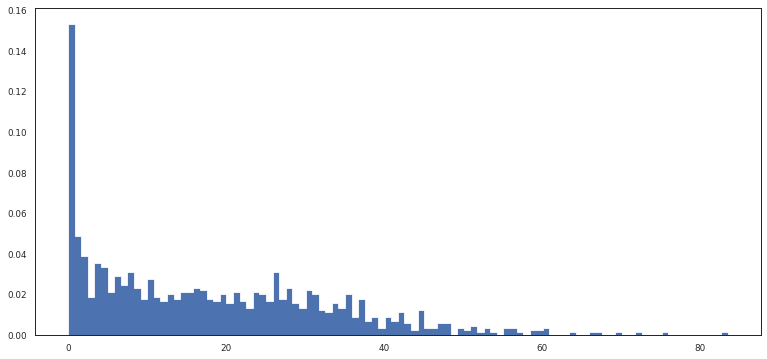

In [87]:
train_area = train_dic.values()

plt.hist(train_area, bins=100, density=True, alpha=1.0, histtype='stepfilled')
plt.show()

* [참고:18. Matplotlib 히스토그램 그리기](https://wikidocs.net/92112)

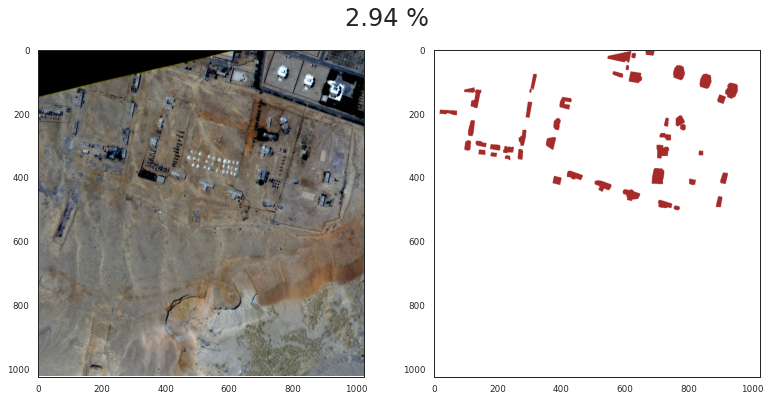

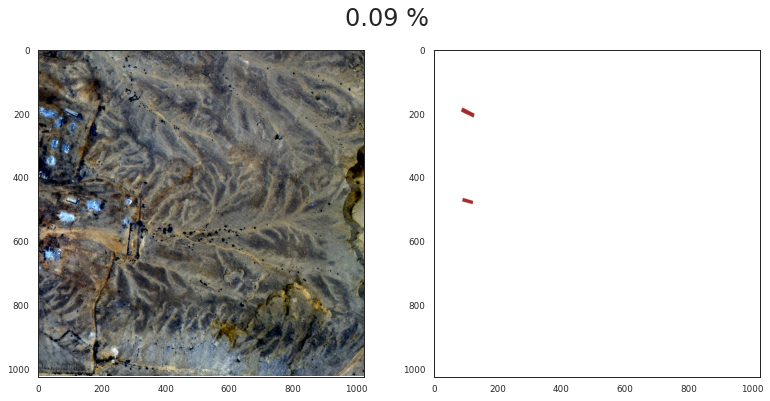

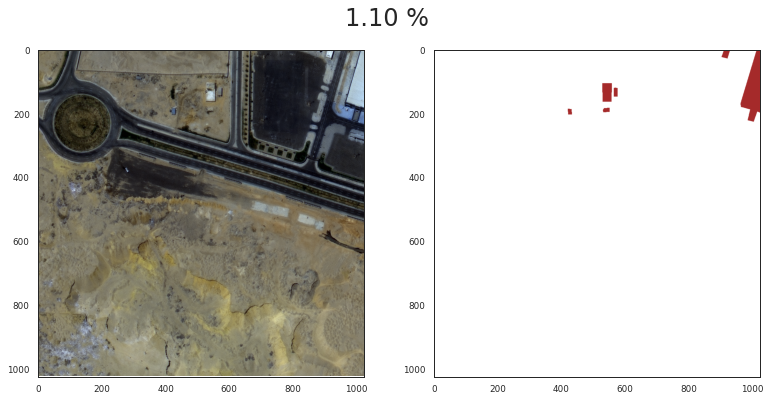

In [99]:
import matplotlib.pyplot as plt

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.rc('figure', figsize=(13,6))
    plt.rc('font', size=20)

    
    plt.suptitle('2.94 %')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][4])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][4])
    plt.show()
    
    plt.suptitle('0.09 %')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][9])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][9])
    plt.show()
    
    plt.suptitle('1.10 %')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][24])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][24])
    plt.show()


### valid

In [88]:
with h5py.File(FILE_PATH, "a") as f:
    val_size = f[VAL_IMG_PATH].shape[0]
    if 'filtered' in f[BASE_VAL_DIR].keys(): del f[VAL_FILTER_DIR]
    f[BASE_VAL_DIR].create_group('filtered')
    f[BASE_VAL_DIR]['filtered'].create_dataset('img', (val_size, 1024, 1024, 3), np.uint8)
    f[BASE_VAL_DIR]['filtered'].create_dataset('label', (val_size, 1024, 1024), np.float32)    
    
    cnt = 0
    valid_dic = {}
    for i in tqdm(range(f[VAL_IMG_PATH].shape[0])):
        img = f[VAL_IMG_PATH][i]
        mask = (f[VAL_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        total = 1024*1024
        building_area = mask.sum()
        area_pct = (building_area / total)*100
        print(f'Index: {i},  Area: {area_pct:.2f} %')
        valid_dic[f'{i:04d}'] = float(f'{area_pct:.2f}')
        
        if area_pct >= LIMIT_AREA_PERCENT:
            f[VAL_FILTER_DIR]['img'][i, ...] = img
            f[VAL_FILTER_DIR]['label'][i, ...] = mask
            cnt +=1
    print(cnt)  

  7%|▋         | 10/150 [00:00<00:03, 46.21it/s]

Index: 0,  Area: 18.76 %
Index: 1,  Area: 38.45 %
Index: 2,  Area: 0.69 %
Index: 3,  Area: 37.72 %
Index: 4,  Area: 14.81 %
Index: 5,  Area: 37.71 %
Index: 6,  Area: 18.72 %
Index: 7,  Area: 5.82 %
Index: 8,  Area: 13.35 %
Index: 9,  Area: 7.91 %


 13%|█▎        | 20/150 [00:00<00:02, 46.81it/s]

Index: 10,  Area: 0.82 %
Index: 11,  Area: 0.04 %
Index: 12,  Area: 17.86 %
Index: 13,  Area: 45.04 %
Index: 14,  Area: 80.63 %
Index: 15,  Area: 14.15 %
Index: 16,  Area: 3.64 %
Index: 17,  Area: 49.72 %
Index: 18,  Area: 6.36 %
Index: 19,  Area: 7.50 %


 17%|█▋        | 25/150 [00:00<00:02, 47.02it/s]

Index: 20,  Area: 5.08 %
Index: 21,  Area: 29.69 %
Index: 22,  Area: 44.24 %
Index: 23,  Area: 0.82 %
Index: 24,  Area: 9.54 %
Index: 25,  Area: 28.51 %
Index: 26,  Area: 0.36 %
Index: 27,  Area: 30.86 %
Index: 28,  Area: 0.68 %
Index: 29,  Area: 0.70 %


 24%|██▍       | 36/150 [00:00<00:02, 47.08it/s]

Index: 30,  Area: 4.00 %
Index: 31,  Area: 14.40 %
Index: 32,  Area: 11.44 %
Index: 33,  Area: 9.69 %
Index: 34,  Area: 14.83 %
Index: 35,  Area: 34.34 %
Index: 36,  Area: 44.05 %
Index: 37,  Area: 40.12 %
Index: 38,  Area: 36.68 %
Index: 39,  Area: 19.18 %


 31%|███       | 46/150 [00:00<00:02, 45.18it/s]

Index: 40,  Area: 20.50 %
Index: 41,  Area: 35.83 %
Index: 42,  Area: 29.63 %
Index: 43,  Area: 10.32 %
Index: 44,  Area: 29.98 %
Index: 45,  Area: 4.33 %
Index: 46,  Area: 38.91 %
Index: 47,  Area: 21.29 %
Index: 48,  Area: 0.67 %
Index: 49,  Area: 4.45 %


 37%|███▋      | 56/150 [00:01<00:02, 46.12it/s]

Index: 50,  Area: 41.34 %
Index: 51,  Area: 1.29 %
Index: 52,  Area: 7.92 %
Index: 53,  Area: 24.24 %
Index: 54,  Area: 13.07 %
Index: 55,  Area: 14.27 %
Index: 56,  Area: 7.12 %
Index: 57,  Area: 28.54 %
Index: 58,  Area: 9.39 %
Index: 59,  Area: 40.04 %


 44%|████▍     | 66/150 [00:01<00:01, 44.85it/s]

Index: 60,  Area: 13.31 %
Index: 61,  Area: 9.19 %
Index: 62,  Area: 24.15 %
Index: 63,  Area: 1.21 %
Index: 64,  Area: 16.90 %
Index: 65,  Area: 5.62 %
Index: 66,  Area: 14.94 %
Index: 67,  Area: 0.68 %
Index: 68,  Area: 7.54 %
Index: 69,  Area: 0.58 %


 51%|█████▏    | 77/150 [00:01<00:01, 48.55it/s]

Index: 70,  Area: 17.98 %
Index: 71,  Area: 0.02 %
Index: 72,  Area: 2.72 %
Index: 73,  Area: 13.04 %
Index: 74,  Area: 0.48 %
Index: 75,  Area: 0.01 %
Index: 76,  Area: 0.05 %
Index: 77,  Area: 0.56 %
Index: 78,  Area: 2.06 %
Index: 79,  Area: 1.76 %
Index: 80,  Area: 9.50 %


 59%|█████▊    | 88/150 [00:01<00:01, 47.45it/s]

Index: 81,  Area: 0.36 %
Index: 82,  Area: 7.49 %
Index: 83,  Area: 0.04 %
Index: 84,  Area: 0.19 %
Index: 85,  Area: 0.82 %
Index: 86,  Area: 0.01 %
Index: 87,  Area: 0.12 %
Index: 88,  Area: 0.01 %
Index: 89,  Area: 0.05 %


 65%|██████▌   | 98/150 [00:02<00:01, 46.25it/s]

Index: 90,  Area: 8.39 %
Index: 91,  Area: 0.21 %
Index: 92,  Area: 6.04 %
Index: 93,  Area: 0.18 %
Index: 94,  Area: 7.59 %
Index: 95,  Area: 12.69 %
Index: 96,  Area: 19.72 %
Index: 97,  Area: 16.60 %
Index: 98,  Area: 18.32 %
Index: 99,  Area: 41.52 %


 72%|███████▏  | 108/150 [00:02<00:00, 46.85it/s]

Index: 100,  Area: 29.98 %
Index: 101,  Area: 16.13 %
Index: 102,  Area: 15.76 %
Index: 103,  Area: 4.97 %
Index: 104,  Area: 44.51 %
Index: 105,  Area: 29.43 %
Index: 106,  Area: 32.94 %
Index: 107,  Area: 11.53 %
Index: 108,  Area: 26.75 %
Index: 109,  Area: 9.91 %


 79%|███████▊  | 118/150 [00:02<00:00, 44.87it/s]

Index: 110,  Area: 24.53 %
Index: 111,  Area: 17.82 %
Index: 112,  Area: 23.53 %
Index: 113,  Area: 10.88 %
Index: 114,  Area: 0.01 %
Index: 115,  Area: 10.56 %
Index: 116,  Area: 31.51 %
Index: 117,  Area: 6.09 %
Index: 118,  Area: 18.49 %


 85%|████████▌ | 128/150 [00:02<00:00, 45.32it/s]

Index: 119,  Area: 4.36 %
Index: 120,  Area: 39.34 %
Index: 121,  Area: 14.28 %
Index: 122,  Area: 8.24 %
Index: 123,  Area: 29.37 %
Index: 124,  Area: 8.61 %
Index: 125,  Area: 12.68 %
Index: 126,  Area: 23.47 %
Index: 127,  Area: 25.42 %
Index: 128,  Area: 32.72 %


 92%|█████████▏| 138/150 [00:02<00:00, 44.05it/s]

Index: 129,  Area: 23.11 %
Index: 130,  Area: 29.27 %
Index: 131,  Area: 25.50 %
Index: 132,  Area: 13.42 %
Index: 133,  Area: 8.33 %
Index: 134,  Area: 9.89 %
Index: 135,  Area: 37.46 %
Index: 136,  Area: 10.10 %
Index: 137,  Area: 11.52 %


 95%|█████████▌| 143/150 [00:03<00:00, 38.50it/s]

Index: 138,  Area: 20.17 %
Index: 139,  Area: 17.99 %
Index: 140,  Area: 18.48 %
Index: 141,  Area: 29.94 %
Index: 142,  Area: 21.73 %
Index: 143,  Area: 6.10 %
Index: 144,  Area: 3.64 %


100%|██████████| 150/150 [00:03<00:00, 44.45it/s]

Index: 145,  Area: 15.62 %
Index: 146,  Area: 14.85 %
Index: 147,  Area: 23.22 %
Index: 148,  Area: 28.54 %
Index: 149,  Area: 10.52 %
112


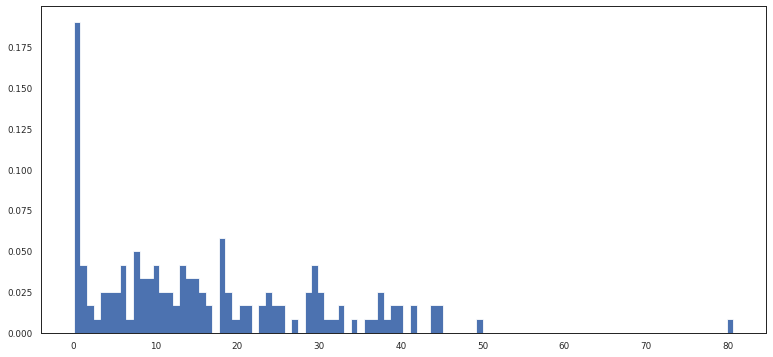

In [89]:
valid_area = valid_dic.values()

plt.hist(valid_area, bins=100, density=True, alpha=1.0, histtype='stepfilled')
plt.show()

### test

In [90]:
with h5py.File(FILE_PATH, "a") as f:
    test_size = f[TEST_IMG_PATH].shape[0]
    if 'filtered' in f[BASE_TEST_DIR].keys(): del f[TEST_FILTER_DIR]
    f[BASE_TEST_DIR].create_group('filtered')
    f[BASE_TEST_DIR]['filtered'].create_dataset('img', (test_size, 1024, 1024, 3), np.uint8)
    f[BASE_TEST_DIR]['filtered'].create_dataset('label', (test_size, 1024, 1024), np.float32)
    
    cnt = 0
    test_dic = {}
    for i in tqdm(range(f[TEST_IMG_PATH].shape[0])):
        img = f[TEST_IMG_PATH][i]
        mask = (f[TEST_LABEL_PATH][i] == COLOR_MAP[0])
        mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
        total = 1024*1024
        building_area = mask.sum()
        area_pct = (building_area / total)*100
        print(f'Index: {i},  Area: {area_pct:.2f} %')
        test_dic[f'{i:04d}'] = float(f'{area_pct:.2f}')
        
        if area_pct >= LIMIT_AREA_PERCENT:
            f[TEST_FILTER_DIR]['img'][i, ...] = img
            f[TEST_FILTER_DIR]['label'][i, ...] = mask
            cnt +=1
    print(cnt)  

  6%|▋         | 10/159 [00:00<00:03, 44.83it/s]

Index: 0,  Area: 27.23 %
Index: 1,  Area: 12.26 %
Index: 2,  Area: 24.03 %
Index: 3,  Area: 34.80 %
Index: 4,  Area: 5.69 %
Index: 5,  Area: 30.77 %
Index: 6,  Area: 15.05 %
Index: 7,  Area: 34.40 %
Index: 8,  Area: 26.11 %
Index: 9,  Area: 20.82 %


 13%|█▎        | 20/159 [00:00<00:03, 45.75it/s]

Index: 10,  Area: 42.00 %
Index: 11,  Area: 36.47 %
Index: 12,  Area: 40.48 %
Index: 13,  Area: 5.89 %
Index: 14,  Area: 44.28 %
Index: 15,  Area: 42.28 %
Index: 16,  Area: 45.42 %
Index: 17,  Area: 38.74 %
Index: 18,  Area: 34.39 %
Index: 19,  Area: 30.43 %


 16%|█▌        | 25/159 [00:00<00:02, 45.15it/s]

Index: 20,  Area: 24.44 %
Index: 21,  Area: 18.75 %
Index: 22,  Area: 43.50 %
Index: 23,  Area: 7.44 %
Index: 24,  Area: 25.48 %
Index: 25,  Area: 26.79 %
Index: 26,  Area: 11.80 %
Index: 27,  Area: 23.81 %
Index: 28,  Area: 36.49 %


 22%|██▏       | 35/159 [00:00<00:03, 39.48it/s]

Index: 29,  Area: 19.34 %
Index: 30,  Area: 0.73 %
Index: 31,  Area: 9.33 %
Index: 32,  Area: 51.36 %
Index: 33,  Area: 60.12 %
Index: 34,  Area: 62.06 %
Index: 35,  Area: 55.70 %


 25%|██▌       | 40/159 [00:00<00:03, 37.59it/s]

Index: 36,  Area: 4.46 %
Index: 37,  Area: 38.10 %
Index: 38,  Area: 56.19 %
Index: 39,  Area: 70.07 %
Index: 40,  Area: 1.87 %
Index: 41,  Area: 37.88 %
Index: 42,  Area: 40.28 %


 31%|███       | 49/159 [00:01<00:03, 36.65it/s]

Index: 43,  Area: 12.30 %
Index: 44,  Area: 6.60 %
Index: 45,  Area: 4.46 %
Index: 46,  Area: 19.01 %
Index: 47,  Area: 0.50 %
Index: 48,  Area: 41.00 %
Index: 49,  Area: 4.92 %
Index: 50,  Area: 20.56 %


 36%|███▌      | 57/159 [00:01<00:02, 35.79it/s]

Index: 51,  Area: 44.33 %
Index: 52,  Area: 20.79 %
Index: 53,  Area: 8.31 %
Index: 54,  Area: 0.35 %
Index: 55,  Area: 18.45 %
Index: 56,  Area: 42.31 %
Index: 57,  Area: 10.95 %
Index: 58,  Area: 45.22 %


 41%|████      | 65/159 [00:01<00:02, 34.07it/s]

Index: 59,  Area: 53.38 %
Index: 60,  Area: 16.50 %
Index: 61,  Area: 28.13 %
Index: 62,  Area: 52.78 %
Index: 63,  Area: 76.21 %
Index: 64,  Area: 30.62 %
Index: 65,  Area: 33.07 %


 46%|████▌     | 73/159 [00:01<00:02, 34.01it/s]

Index: 66,  Area: 53.70 %
Index: 67,  Area: 23.24 %
Index: 68,  Area: 35.26 %
Index: 69,  Area: 35.68 %
Index: 70,  Area: 8.45 %
Index: 71,  Area: 3.85 %
Index: 72,  Area: 1.54 %
Index: 73,  Area: 12.94 %


 51%|█████     | 81/159 [00:02<00:02, 34.83it/s]

Index: 74,  Area: 41.04 %
Index: 75,  Area: 28.43 %
Index: 76,  Area: 38.25 %
Index: 77,  Area: 39.82 %
Index: 78,  Area: 34.80 %
Index: 79,  Area: 2.61 %
Index: 80,  Area: 35.34 %
Index: 81,  Area: 29.59 %


 56%|█████▌    | 89/159 [00:02<00:01, 35.32it/s]

Index: 82,  Area: 27.76 %
Index: 83,  Area: 36.69 %
Index: 84,  Area: 33.07 %
Index: 85,  Area: 37.43 %
Index: 86,  Area: 21.29 %
Index: 87,  Area: 11.77 %
Index: 88,  Area: 44.85 %
Index: 89,  Area: 28.23 %


 61%|██████    | 97/159 [00:02<00:01, 35.67it/s]

Index: 90,  Area: 5.64 %
Index: 91,  Area: 41.08 %
Index: 92,  Area: 26.98 %
Index: 93,  Area: 14.88 %
Index: 94,  Area: 2.07 %
Index: 95,  Area: 28.74 %
Index: 96,  Area: 17.52 %
Index: 97,  Area: 10.70 %


 67%|██████▋   | 106/159 [00:02<00:01, 37.65it/s]

Index: 98,  Area: 2.32 %
Index: 99,  Area: 1.25 %
Index: 100,  Area: 37.52 %
Index: 101,  Area: 35.23 %
Index: 102,  Area: 28.56 %
Index: 103,  Area: 45.57 %
Index: 104,  Area: 21.91 %
Index: 105,  Area: 20.15 %
Index: 106,  Area: 49.54 %


 73%|███████▎  | 116/159 [00:03<00:01, 42.56it/s]

Index: 107,  Area: 3.54 %
Index: 108,  Area: 1.69 %
Index: 109,  Area: 25.47 %
Index: 110,  Area: 3.98 %
Index: 111,  Area: 16.28 %
Index: 112,  Area: 13.90 %
Index: 113,  Area: 5.52 %
Index: 114,  Area: 3.67 %
Index: 115,  Area: 1.17 %
Index: 116,  Area: 16.51 %


 80%|███████▉  | 127/159 [00:03<00:00, 46.15it/s]

Index: 117,  Area: 4.08 %
Index: 118,  Area: 3.35 %
Index: 119,  Area: 1.50 %
Index: 120,  Area: 5.01 %
Index: 121,  Area: 5.54 %
Index: 122,  Area: 15.64 %
Index: 123,  Area: 15.83 %
Index: 124,  Area: 25.22 %
Index: 125,  Area: 7.13 %
Index: 126,  Area: 0.50 %
Index: 127,  Area: 3.87 %


 86%|████████▌ | 137/159 [00:03<00:00, 46.15it/s]

Index: 128,  Area: 25.65 %
Index: 129,  Area: 31.09 %
Index: 130,  Area: 26.85 %
Index: 131,  Area: 35.14 %
Index: 132,  Area: 24.90 %
Index: 133,  Area: 35.92 %
Index: 134,  Area: 30.76 %
Index: 135,  Area: 40.91 %
Index: 136,  Area: 12.65 %
Index: 137,  Area: 21.15 %


 92%|█████████▏| 147/159 [00:03<00:00, 46.09it/s]

Index: 138,  Area: 24.09 %
Index: 139,  Area: 31.68 %
Index: 140,  Area: 30.10 %
Index: 141,  Area: 16.99 %
Index: 142,  Area: 33.74 %
Index: 143,  Area: 0.23 %
Index: 144,  Area: 30.74 %
Index: 145,  Area: 27.93 %
Index: 146,  Area: 23.47 %
Index: 147,  Area: 19.98 %


 99%|█████████▊| 157/159 [00:03<00:00, 46.00it/s]

Index: 148,  Area: 4.72 %
Index: 149,  Area: 25.56 %
Index: 150,  Area: 24.25 %
Index: 151,  Area: 35.74 %
Index: 152,  Area: 15.31 %
Index: 153,  Area: 25.27 %
Index: 154,  Area: 20.65 %
Index: 155,  Area: 29.41 %
Index: 156,  Area: 31.16 %
Index: 157,  Area: 4.23 %


100%|██████████| 159/159 [00:03<00:00, 40.06it/s]

Index: 158,  Area: 27.02 %
133


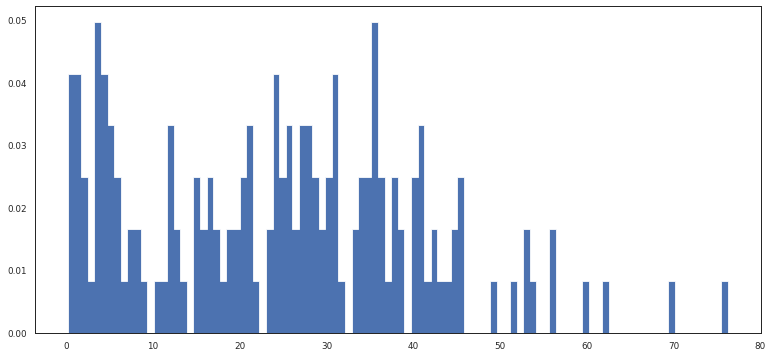

In [91]:
test_area = test_dic.values()

plt.hist(test_area, bins=100, density=True, alpha=1.0, histtype='stepfilled', color='b')
plt.show()

* Area percent : train / valid / test
  * 5% 미만 : 297 / 38 /  26
  * 5% 이상 : 791 / 112 / 133
  * 10% 미만 : 428 / 63 /  38
  * 10% 이상 : 660 / 87 / 121

### filtered dataset 확인

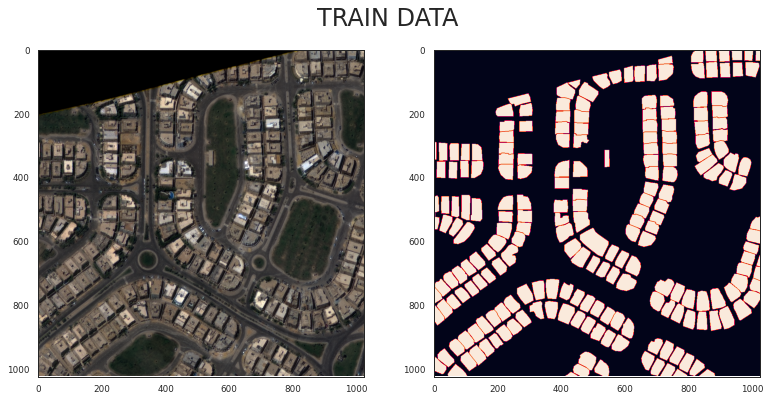

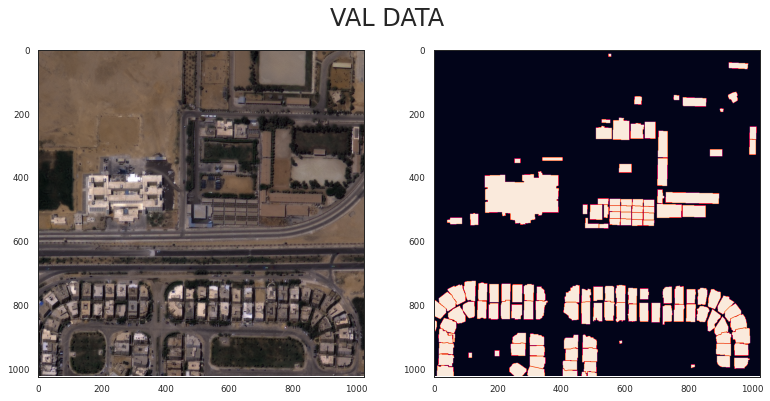

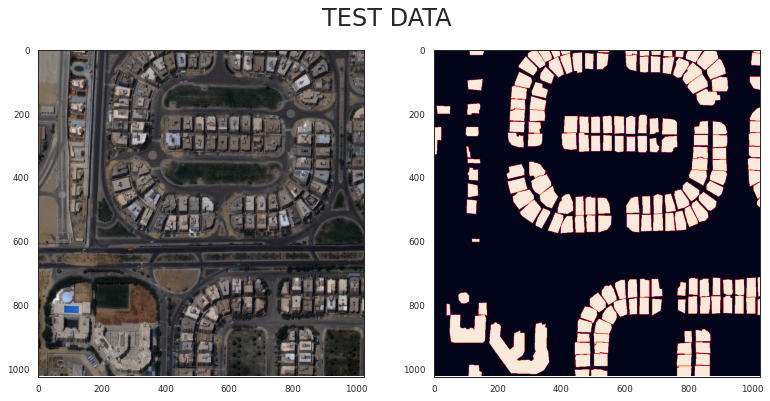

In [94]:
import matplotlib.pyplot as plt
i = 0

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.rc('figure', figsize=(13,6))
    plt.rc('font', size=20)

    
    plt.suptitle('TRAIN DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_FILTER_IMG_PATH][i])  
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_FILTER_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('VAL DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[VAL_FILTER_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[VAL_FILTER_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('TEST DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TEST_FILTER_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TEST_FILTER_LABEL_PATH][i])
    plt.show()

## Cropped 빌딩 라벨 분율이 설정값 이상인 경우 저장

In [158]:
CROP_LIMIT_AREA_PERCENT = 10
CROP_NUM = 25
CROP_HEIGHT, CROP_WIDTH = 256, 256 

### Random crop을 위한 함수 정의

In [185]:
# https://github.com/matterport/Mask_RCNN/issues/230
def random_crop(img, mask, height=256, width=256):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    pos_x, pos_y = x, y
    
    img = img[y:y+height, x:x+width]
    mask = mask[y:y+height, x:x+width]
    
    return img, mask, pos_x, pos_y

In [240]:
def crop_repeat(img, mask, crop_num=25):
    croped_image, croped_mask = [], []
    
    for i in range(crop_num):
        crop_img, crop_mask, pos_x, pos_y = random_crop(img, mask, height=CROP_HEIGHT, width=CROP_WIDTH)
        
        crop_mask = (crop_mask == COLOR_MAP[0])
        crop_mask = (crop_mask[:,:,0] + crop_mask[:,:,1] + crop_mask[:,:,2]).astype(np.float32)  
        total_area = CROP_HEIGHT*CROP_WIDTH
        crop_area = crop_mask.sum()
        crop_area_pct = (crop_area / total_area)*100
#         print(f'Crop index: {i},  Area: {crop_area_pct:.2f} %')

        if crop_area_pct >= CROP_LIMIT_AREA_PERCENT:
            croped_image.append(crop_img)
            croped_mask.append(crop_mask)  
            crop_area_lists.append(crop_area_pct)
            crop_pts.append((pos_x, pos_x+CROP_WIDTH, pos_y, pos_y+CROP_HEIGHT))
                             
    
    return croped_image, croped_mask, crop_pts, crop_area_lists

In [161]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
        
    return i

### 이미지 1장 테스트

In [228]:
with h5py.File(FILE_PATH, "a") as f:
    
       
    train_size = f[TRAIN_IMG_PATH].shape[0]
    
    if 'filtered' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_FILTER_DIR]
    f[BASE_TARIN_DIR].create_group('filtered')
    f[BASE_TARIN_DIR]['filtered'].create_dataset('img', (train_size, 1024, 1024, 3), np.uint8)
    f[BASE_TARIN_DIR]['filtered'].create_dataset('label', (train_size, 1024, 1024), np.float32)
    
    if 'crop_filtered' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_CROP_FILTER_DIR]    
    f[BASE_TARIN_DIR].create_group('crop_filtered')
    f[BASE_TARIN_DIR]['crop_filtered'].create_dataset('img', (train_size*crop_num, CROP_HEIGHT, CROP_WIDTH, 3), np.uint8)
    f[BASE_TARIN_DIR]['crop_filtered'].create_dataset('label', (train_size*crop_num, CROP_HEIGHT, CROP_WIDTH), np.float32)    
    
    i = 0
    sub_idx = 0
    crop_area_list, crop_pts = [], []
    img = f[TRAIN_IMG_PATH][i]
    label = f[TRAIN_LABEL_PATH][i]
    label_mask = (label == COLOR_MAP[0])
    filter_mask = (label_mask[:,:,0] + label_mask[:,:,1] + label_mask[:,:,2]).astype(np.float32)
    filter_total_area = filter_mask.shape[0]*filter_mask.shape[1]
    filtered_area = filter_mask.sum()
    area_pct = (filtered_area / filter_total_area)*100
    print(f'Index: {i},  Area: {area_pct:.2f} %')
    train_dic[f'{i:04d}'] = float(f'{area_pct:.2f}')  
    
    if area_pct >= LIMIT_AREA_PERCENT:
        f[TRAIN_FILTER_DIR]['img'][i, ...] = img
        f[TRAIN_FILTER_DIR]['label'][i, ...] = filter_mask
        
        croped_image, croped_mask, crop_pts, crop_area_list = crop_repeat(img, label, CROP_NUM)
        sub_idx = save_png_imgs_labels(f[TRAIN_CROP_FILTER_DIR], sub_idx, croped_image, croped_mask)

Index: 0,  Area: 33.53 %


* [참고: Albumentation 사용해서 Augmentation하기](https://hwiyong.tistory.com/397)

# of crop images: 24


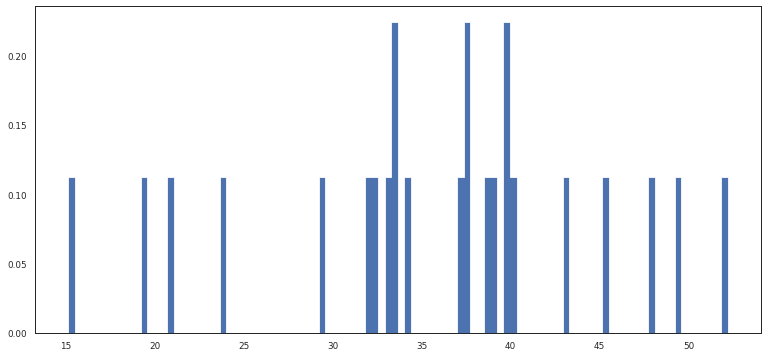

In [231]:
print("# of crop images:", len(crop_area_list))

plt.hist(crop_area_list, bins=100, density=True, alpha=1.0, histtype='stepfilled', color='b')
plt.show()

### crop train dataset

In [241]:
with h5py.File(FILE_PATH, "a") as f:
    batch_size = f[TRAIN_IMG_PATH].shape[0]
    
    if 'filtered' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_FILTER_DIR]
    f[BASE_TARIN_DIR].create_group('filtered')
    f[BASE_TARIN_DIR]['filtered'].create_dataset('img', (batch_size, 1024, 1024, 3), np.uint8)
    f[BASE_TARIN_DIR]['filtered'].create_dataset('label', (batch_size, 1024, 1024), np.float32)
    
    if 'crop_filtered' in f[BASE_TARIN_DIR].keys(): del f[TRAIN_CROP_FILTER_DIR]    
    f[BASE_TARIN_DIR].create_group('crop_filtered')
    f[BASE_TARIN_DIR]['crop_filtered'].create_dataset('img', (batch_size*crop_num, CROP_HEIGHT, CROP_WIDTH, 3), np.uint8)
    f[BASE_TARIN_DIR]['crop_filtered'].create_dataset('label', (batch_size*crop_num, CROP_HEIGHT, CROP_WIDTH), np.float32)    
     
    cnt = 0
    sub_idx = 0
    crop_area_lists, crop_pts = [], []
    for i in tqdm(range(f[TRAIN_IMG_PATH].shape[0])):
        img = f[TRAIN_IMG_PATH][i]
        label = f[TRAIN_LABEL_PATH][i]
        label_mask = (label == COLOR_MAP[0])
        
        filter_mask = (label_mask[:,:,0] + label_mask[:,:,1] + label_mask[:,:,2]).astype(np.float32)
        filter_total_area = filter_mask.shape[0]*filter_mask.shape[1]
        filtered_area = filter_mask.sum()
        area_pct = (filtered_area / filter_total_area)*100

        if area_pct >= LIMIT_AREA_PERCENT:
            f[TRAIN_FILTER_DIR]['img'][i, ...] = img
            f[TRAIN_FILTER_DIR]['label'][i, ...] = filter_mask

            croped_image, croped_mask, crop_pts, crop_area_lists = crop_repeat(img, label, CROP_NUM)
            sub_idx = save_png_imgs_labels(f[TRAIN_CROP_FILTER_DIR], sub_idx, croped_image, croped_mask)            
            
            cnt +=1
            
    print("Total # of filtered image:", cnt)

100%|██████████| 1088/1088 [00:58<00:00, 18.61it/s]

Total # of filtered image: 791


Total # of crop images: 14199


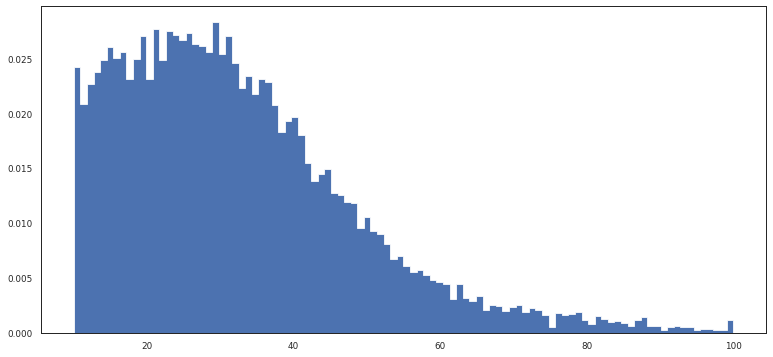

In [242]:
print("Total # of crop images:", len(crop_area_lists))

plt.hist(crop_area_lists, bins=100, density=True, alpha=1.0, histtype='stepfilled')
plt.show()

### crop valid dataset

In [245]:
with h5py.File(FILE_PATH, "a") as f:
    batch_size = f[VAL_IMG_PATH].shape[0]
    
    if 'filtered' in f[BASE_VAL_DIR].keys(): del f[VAL_FILTER_DIR]
    f[BASE_VAL_DIR].create_group('filtered')
    f[BASE_VAL_DIR]['filtered'].create_dataset('img', (batch_size, 1024, 1024, 3), np.uint8)
    f[BASE_VAL_DIR]['filtered'].create_dataset('label', (batch_size, 1024, 1024), np.float32)
    
    if 'crop_filtered' in f[BASE_VAL_DIR].keys(): del f[VAL_CROP_FILTER_DIR]    
    f[BASE_VAL_DIR].create_group('crop_filtered')
    f[BASE_VAL_DIR]['crop_filtered'].create_dataset('img', (batch_size*crop_num, CROP_HEIGHT, CROP_WIDTH, 3), np.uint8)
    f[BASE_VAL_DIR]['crop_filtered'].create_dataset('label', (batch_size*crop_num, CROP_HEIGHT, CROP_WIDTH), np.float32)    
     
    cnt = 0
    sub_idx = 0
    crop_area_lists, crop_pts = [], []
    for i in tqdm(range(f[VAL_IMG_PATH].shape[0])):
        img = f[VAL_IMG_PATH][i]
        label = f[VAL_LABEL_PATH][i]
        label_mask = (label == COLOR_MAP[0])
        
        filter_mask = (label_mask[:,:,0] + label_mask[:,:,1] + label_mask[:,:,2]).astype(np.float32)
        filter_total_area = filter_mask.shape[0]*filter_mask.shape[1]
        filtered_area = filter_mask.sum()
        area_pct = (filtered_area / filter_total_area)*100

        if area_pct >= LIMIT_AREA_PERCENT:
            f[VAL_FILTER_DIR]['img'][i, ...] = img
            f[VAL_FILTER_DIR]['label'][i, ...] = filter_mask

            croped_image, croped_mask, crop_pts, crop_area_lists = crop_repeat(img, label, CROP_NUM)
            sub_idx = save_png_imgs_labels(f[VAL_CROP_FILTER_DIR], sub_idx, croped_image, croped_mask)            
            
            cnt +=1
            
    print("Total # of filtered image:", cnt)

100%|██████████| 150/150 [00:07<00:00, 20.65it/s]

Total # of filtered image: 112


Total # of crop images: 1833


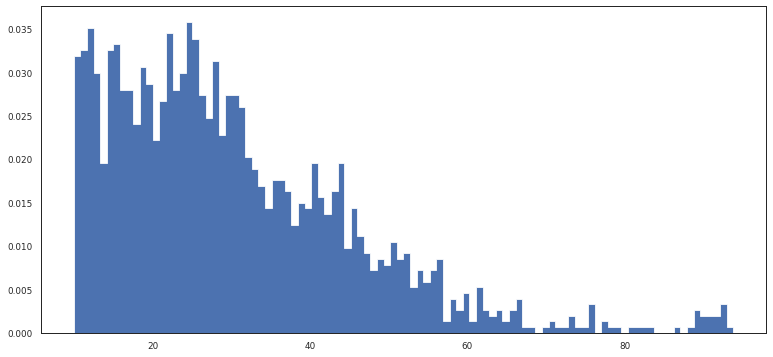

In [247]:
print("Total # of crop images:", len(crop_area_lists))

plt.hist(crop_area_lists, bins=100, density=True, alpha=1.0, histtype='stepfilled')
plt.show()

### crop test dataset

In [248]:
with h5py.File(FILE_PATH, "a") as f:
    batch_size = f[TEST_IMG_PATH].shape[0]
    
    if 'filtered' in f[BASE_TEST_DIR].keys(): del f[TEST_FILTER_DIR]
    f[BASE_TEST_DIR].create_group('filtered')
    f[BASE_TEST_DIR]['filtered'].create_dataset('img', (batch_size, 1024, 1024, 3), np.uint8)
    f[BASE_TEST_DIR]['filtered'].create_dataset('label', (batch_size, 1024, 1024), np.float32)
    
    if 'crop_filtered' in f[BASE_TEST_DIR].keys(): del f[TEST_CROP_FILTER_DIR]    
    f[BASE_TEST_DIR].create_group('crop_filtered')
    f[BASE_TEST_DIR]['crop_filtered'].create_dataset('img', (batch_size*crop_num, CROP_HEIGHT, CROP_WIDTH, 3), np.uint8)
    f[BASE_TEST_DIR]['crop_filtered'].create_dataset('label', (batch_size*crop_num, CROP_HEIGHT, CROP_WIDTH), np.float32)    
     
    cnt = 0
    sub_idx = 0
    crop_area_lists, crop_pts = [], []
    for i in tqdm(range(f[TEST_IMG_PATH].shape[0])):
        img = f[TEST_IMG_PATH][i]
        label = f[TEST_LABEL_PATH][i]
        label_mask = (label == COLOR_MAP[0])
        
        filter_mask = (label_mask[:,:,0] + label_mask[:,:,1] + label_mask[:,:,2]).astype(np.float32)
        filter_total_area = filter_mask.shape[0]*filter_mask.shape[1]
        filtered_area = filter_mask.sum()
        area_pct = (filtered_area / filter_total_area)*100

        if area_pct >= LIMIT_AREA_PERCENT:
            f[TEST_FILTER_DIR]['img'][i, ...] = img
            f[TEST_FILTER_DIR]['label'][i, ...] = filter_mask

            croped_image, croped_mask, crop_pts, crop_area_lists = crop_repeat(img, label, CROP_NUM)
            sub_idx = save_png_imgs_labels(f[TEST_CROP_FILTER_DIR], sub_idx, croped_image, croped_mask)            
            
            cnt +=1
            
    print("Total # of filtered image:", cnt)

100%|██████████| 159/159 [00:08<00:00, 17.81it/s]

Total # of filtered image: 133


Total # of crop images: 2643


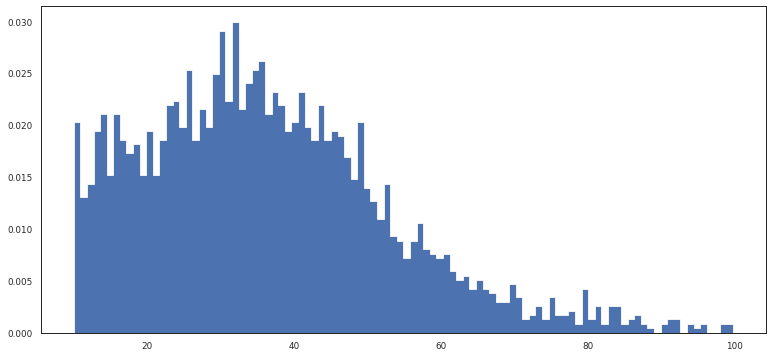

In [249]:
print("Total # of crop images:", len(crop_area_lists))

plt.hist(crop_area_lists, bins=100, density=True, alpha=1.0, histtype='stepfilled')
plt.show()

### cropped dataset 확인

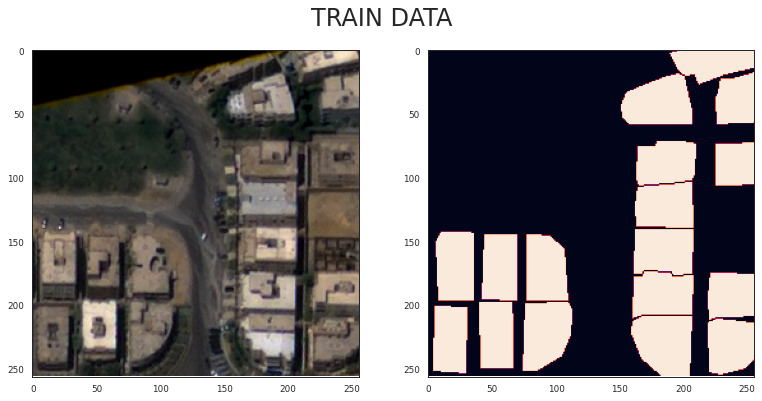

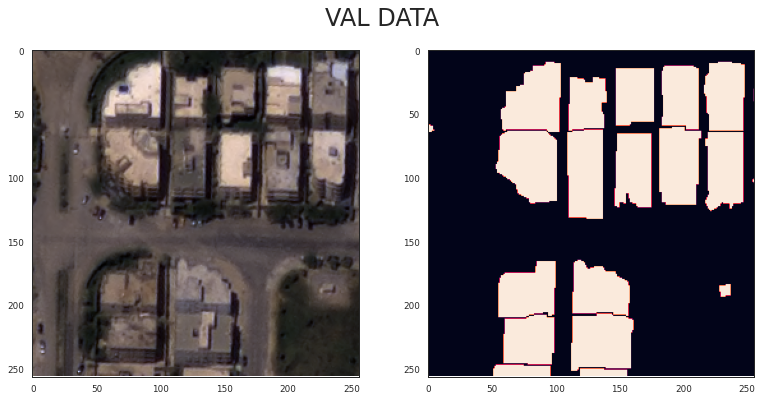

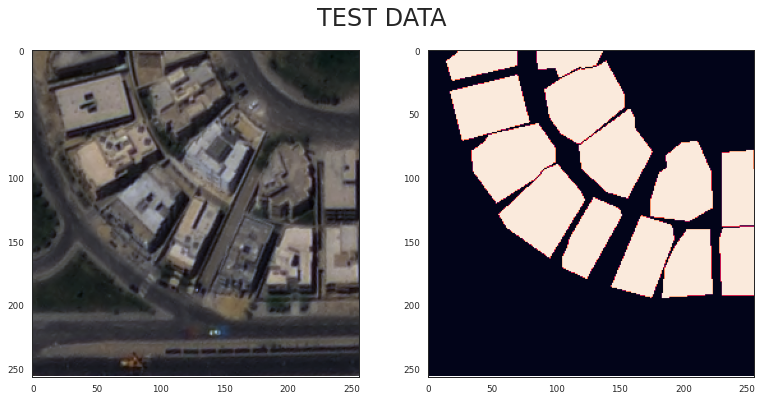

In [171]:
import matplotlib.pyplot as plt
i = 0

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.rc('figure', figsize=(13,6))
    plt.rc('font', size=20)

    
    plt.suptitle('TRAIN DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_CROP_FILTER_IMG_PATH][i])  
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_CROP_FILTER_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('VAL DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[VAL_CROP_FILTER_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[VAL_CROP_FILTER_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle('TEST DATA')
    plt.subplot(121)
    plt.imshow(hdf5_file[TEST_CROP_FILTER_IMG_PATH][i])
    plt.subplot(122)
    plt.imshow(hdf5_file[TEST_CROP_FILTER_LABEL_PATH][i])
    plt.show()

## Dataloader and utility를 위한 함수

### Utility 함수

In [172]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [173]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

#### round(), clip(), rotation90(), CLAHE

In [174]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = [
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

* [참고: albumentations - fast image augmentation library 소개 및 사용법 Tutorial](https://hoya012.github.io/blog/albumentation_tutorial/)
* [참고: albumentations example(google colab)](https://hoya012.github.io/blog/albumentation_tutorial/)

### Generator 클래스

In [175]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    ref: https://github.com/AIFFEL-FREESIA/Model/blob/master/Unet_building_256_2.ipynb
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 filepath,
                 x_path,
                 y_path,
                 batch_size=8,
                 augmentation=None, 
                 preprocessing=None,
                 is_train=True):
        
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
            
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

    def __getitem__(self, index):
        with h5py.File(self.filepath, 'r') as f:
            images = f[self.x_path][index*self.batch_size : (index + 1)*self.batch_size]
            masks = f[self.y_path][index*self.batch_size : (index + 1)*self.batch_size]
            res = [(img, mask) for img, mask in zip(images, masks)]

            if self.augmentation:
                res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            if self.preprocessing:
                res = [self.preprocessing(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            
            images = np.array([img for img, _ in res ])
            masks = np.array([mask for _, mask in res ])
            
            return images, masks

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(self.size)
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


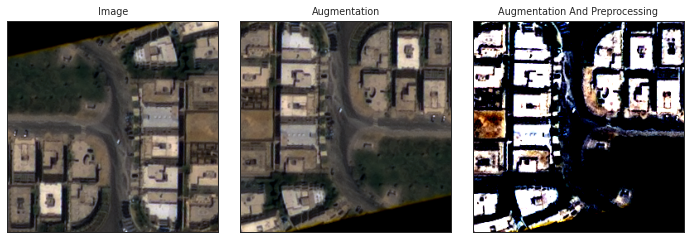

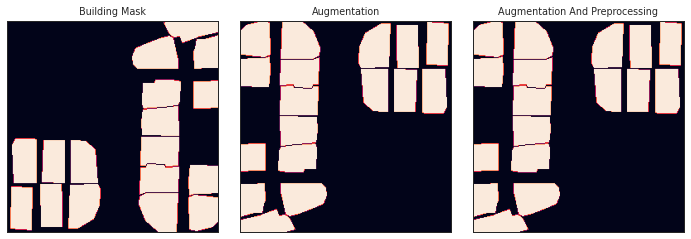

In [181]:
# Lets look at augmented data we have
dataset = SatelliteGenerator(
    FILE_PATH,
    TRAIN_CROP_FILTER_IMG_PATH,
    TRAIN_CROP_FILTER_LABEL_PATH, 
#     augmentation=get_training_augmentation()
)

dataset_aug = SatelliteGenerator(
    FILE_PATH,
    TRAIN_CROP_FILTER_IMG_PATH,
    TRAIN_CROP_FILTER_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')

dataset_aug_pre = SatelliteGenerator(
    FILE_PATH,
    TRAIN_CROP_FILTER_IMG_PATH,
    TRAIN_CROP_FILTER_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

idx = 0
image, mask = dataset[idx]              # get some sample
image_aug, mask_aug = dataset_aug[idx]
image_aug_pre, mask_aug_pre = dataset_aug_pre[idx]


visualize(
    image=image[0], 
    augmentation=image_aug[0],
    augmentation_and_preprocessing=denormalize(image_aug_pre[0])
)

visualize(
    building_mask=mask[0],
    augmentation=mask_aug[0],
    augmentation_and_preprocessing=mask_aug_pre[0]
)

* [참고: Segmentation models](https://segmentation-models.readthedocs.io/en/latest/tutorial.html)

## Train Model

### train을 위한 함수 정의

In [177]:
def get_datagenerator(BATCH_SIZE=8, BACKBONE='efficientnetb3'):
    # Dataset for train images
    preprocess_input = sm.get_preprocessing(BACKBONE)
    
    train_datagenerator = SatelliteGenerator(
        FILE_PATH,
        TRAIN_CROP_FILTER_IMG_PATH,
        TRAIN_CROP_FILTER_LABEL_PATH,
        batch_size=BATCH_SIZE,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=True
    )

    # Dataset for validation image
    valid_datagenerator = SatelliteGenerator(
        FILE_PATH,
        VAL_CROP_FILTER_IMG_PATH, 
        VAL_CROP_FILTER_LABEL_PATH, 
        batch_size=BATCH_SIZE,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=False
    )

    return train_datagenerator, valid_datagenerator

In [178]:
import time
import datetime

def logging_time(original_fn):
    def wrapper_fn(*args, **kwargs):
        start_time = time.time()
        
        result = original_fn(*args, **kwargs)
        
        sec = time.time()-start_time
        times = str(datetime.timedelta(seconds=sec)).split(".")
        times = times[0]
        print(f'WorkingTime : {times}')
        
        return result
    
    return wrapper_fn

In [179]:
def get_cosine_lr(initial_learning_rate, t_period, lr_min=0.):
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)

In [182]:
def get_model(model_name, optim, train, valid, MODEL_PATH, patience=5):
    BACKBONE = 'efficientnetb3'
    CLASSES = ['building']

    # define network parameters
    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    #create model
    tf.random.set_seed(2021)
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    
    log_dir = f"./logs/fit/{model_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    callbacks = [
        keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                          factor=0.1, 
                                          patience=5, 
                                          verbose=1, 
                                          mode='min'),
        tensorboard_callback,
        keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ]
    
    return model, callbacks

In [183]:
def show_history_plot(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    keys = [('loss', 'val_loss'), ('iou_score', 'val_iou_score'), ('f1-score', 'val_f1-score')]
    
    for (train, val), ax in zip(keys, axes):
        ax.plot(history[train])
        ax.plot(history[val])
        ax.set_title(f'Model {train}')
        ax.set_ylabel(train)
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
# show_history_plot(new_history)

## E12-1B

### Fit parameters setting

In [196]:
lr = 1e-4
BATCH_SIZE = 8      # for PC, 32: for cloud
EPOCHS = 100
CROP_NUM = 25

optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [197]:
model_12_1B, callbacks = get_model('E12-1B',
                                  optim,
                                  train_datagenerator, 
                                  valid_datagenerator,
                                  SAVE_MODEL_PATH +'/E12_1B.h5',
                                  patience=10)

In [198]:
start_time = time.time()

history_12_1B = model_12_1B.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
3400/3400 [==============================] - 765s 222ms/step - loss: 0.7191 - iou_score: 0.4198 - f1-score: 0.4957 - val_loss: 0.7394 - val_iou_score: 0.7763 - val_f1-score: 0.8491
Epoch 2/100
3400/3400 [==============================] - 745s 219ms/step - loss: 0.6321 - iou_score: 0.7764 - f1-score: 0.8395 - val_loss: 0.8500 - val_iou_score: 0.7020 - val_f1-score: 0.7754
Epoch 3/100
3400/3400 [==============================] - 749s 220ms/step - loss: 0.6126 - iou_score: 0.8480 - f1-score: 0.9056 - val_loss: 0.7607 - val_iou_score: 0.7515 - val_f1-score: 0.8276
Epoch 4/100
3400/3400 [==============================] - 747s 220ms/step - loss: 0.6118 - iou_score: 0.8488 - f1-score: 0.9021 - val_loss: 0.7118 - val_iou_score: 0.8040 - val_f1-score: 0.8730
Epoch 5/100
3400/3400 [==============================] - 742s 218ms/step - loss: 0.6009 - iou_score: 0.8427 - f1-score: 0.8941 - val_loss: 0.7778 - val_iou_score: 0.7519 - val_f1-score: 0.8253
Epoch 6/100
3400/3400 [============

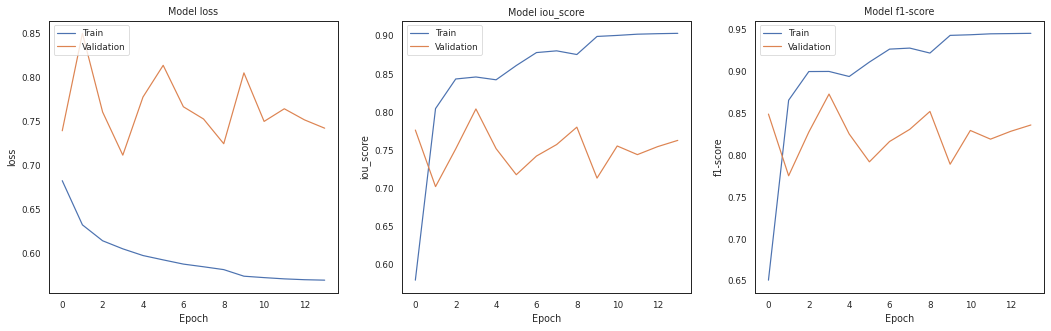

In [200]:
show_history_plot(history_12_1B.history)

### Random crop한 경우에 Evaluation을 위한 함수 정의

In [ ]:
# IMG_SIZE = 1024
# CROP_SIZE = 256
# SPLIT_CNT = 5
# STRIDE_SIZE = int((IMG_SIZE - CROP_SIZE)/(SPLIT_CNT - 1))
# print('Stride size:', STRIDE_SIZE)

In [187]:
# def inference(model, img, pts):
#     preprocessing = A.Compose([
#         A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
#         A.Lambda(image=sm.get_preprocessing(BACKBONE)),
#     ])

#     sub_imgs = img
#     sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]

#     sub_imgs = [np.expand_dims(sub_img, axis=0) for sub_img in sub_imgs]
#     pre_imgs = [model.predict(sub_img) for sub_img in sub_imgs]
#     pre_imgs = [pre_img[..., 0].squeeze() for pre_img in pre_imgs]
#     pre_imgs = [pre_img.round().clip(0, 1) for pre_img in pre_imgs]

#     merged = np.zeros((1024, 1024))
#     for i, (x0, x1, y0, y1) in enumerate(pts) : 
#         sub = (merged[x0:x1, y0:y1] + pre_imgs[i])/2
#         sub = np.where(sub - sub//1 > 0, sub+0.00001, sub)
#         sub = np.round(sub)
#         merged[x0:x1, y0:y1] = sub
        
#     return merged

In [189]:
# def show_inference(model):
#     with h5py.File(FILE_PATH, "r") as f:
#         for idx in range(5):
#             img = f[TEST_IMG_PATH][idx]
#             label = f[TEST_LABEL_PATH][idx]      # ground truth
            
#             mask = (f[TEST_LABEL_PATH][idx] == COLOR_MAP[0])
#             mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)

#             crop_imgs, _, crop_pts = crop_repeat(img, label, CROP_NUM)
            
#             predicted = inference(model, crop_imgs, crop_pts)
#             images = {'Image': img, 
#                       'Ground Truth': mask,
#                       'Prediction': predicted}

#             visualize(
#                 image=img,
#                 ground_truth=mask,
#                 predicted=predicted
#             )

### Slide crop한 경우에 Evaluation을 위한 함수 정의

In [215]:
IMG_SIZE = 1024
CROP_SIZE = 256
SPLIT_CNT = 5
STRIDE_SIZE = int((IMG_SIZE - CROP_SIZE)/(SPLIT_CNT - 1))
print('Stride size:', STRIDE_SIZE)

Stride size: 192


In [216]:
def get_slice_pos(SPLIT_CNT, STRIDE_SIZE, CROP_SIZE):
    crop_pts = []
    for slice_pos in range(SPLIT_CNT*SPLIT_CNT):
        pos_i = int(math.floor(slice_pos / SPLIT_CNT))
        pos_j = int(slice_pos % int(SPLIT_CNT))
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        crop_pts.append((x, x+CROP_SIZE, y, y+CROP_SIZE))
        
    return crop_pts

In [213]:
# def get_crop_imgs(img, height=CROP_HEIGHT, width=CROP_WIDTH):
#     assert img.shape[0] >= height
#     assert img.shape[1] >= width
    
#     crop_imgs = []
#     crop_pts = []
    
#     for slice_pos in range(SPLIT_CNT*SPLIT_CNT):
#         pos_i = int(math.floor(slice_pos / SPLIT_CNT))
#         pos_j = int(slice_pos % int(SPLIT_CNT))
#         x = STRIDE_SIZE * pos_i
#         y = STRIDE_SIZE * pos_j
        
#         crop_pt = (x, x+CROP_SIZE, y, y+CROP_SIZE)
#         crop_pts.append(crop_pt)
        
#         crop_img = img[y:y+height, x:x+width]

#         crop_imgs.append(crop_img)
    
#     return crop_imgs,  crop_pts

In [217]:
def split_png(img, crop_pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in crop_pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in crop_pts]
    return sub_imgs

In [218]:
def inference(model, img, crop_pts):
    preprocessing = A.Compose([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])

#     sub_imgs, crop_pts = get_crop_imgs(img, height=CROP_HEIGHT, width=CROP_WIDTH)
    
    sub_imgs = split_png(img, crop_pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]

    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    predict_imgs = [model.predict(img) for img in sub_imgs]
    predict_imgs = [predict[..., 0].squeeze() for predict in predict_imgs]
    predict_imgs = [predict.round().clip(0, 1) for predict in predict_imgs]
    
    merged_img = np.zeros((1024, 1024))
    for i, (x0, x1, y0, y1) in enumerate(crop_pts) : 
        sub = (merged_img[x0:x1, y0:y1] + predict_imgs[i])/2
        sub = np.where(sub - sub//1 > 0, sub+0.00001, sub)
        sub = np.round(sub)
        merged_img[x0:x1, y0:y1] = sub
        
    return merged_img

In [225]:
def show_inference(model, first, last):
    crop_pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, CROP_SIZE)
    
    with h5py.File(FILE_PATH, "r") as f:
        for idx in range(first,last):
            img = f[TEST_IMG_PATH][idx]
            mask = (f[TEST_LABEL_PATH][idx] == COLOR_MAP[0])
            mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)


            predicted = inference(model, img, crop_pts)
            
            images = {'Image': img, 
                      'Ground Truth': mask,
                      'Prediction': predicted}

            visualize(
                image=img,
                ground_truth=mask,
                predicted=predicted
            )

### Evaluation

In [206]:
model_12_1B.load_weights(SAVE_MODEL_PATH +'/E12_1B.h5')

In [207]:
preprocess_input = sm.get_preprocessing('efficientnetb3')

test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_CROP_FILTER_IMG_PATH, 
    TEST_CROP_FILTER_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)

val_metrix = model_12_1B.evaluate(valid_datagenerator)
test_metrix = model_12_1B.evaluate(test_datagenerator)

497/497 [==============================] - 23s 46ms/step - loss: 0.5783 - iou_score: 0.7689 - f1-score: 0.8546


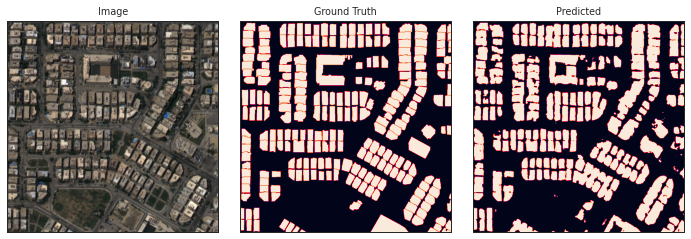

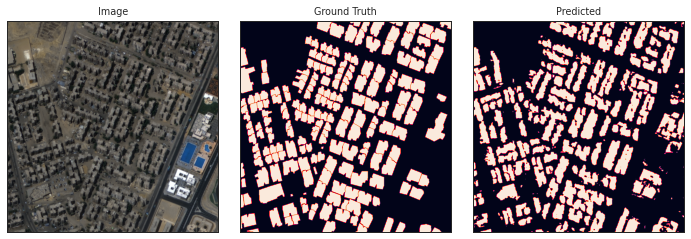

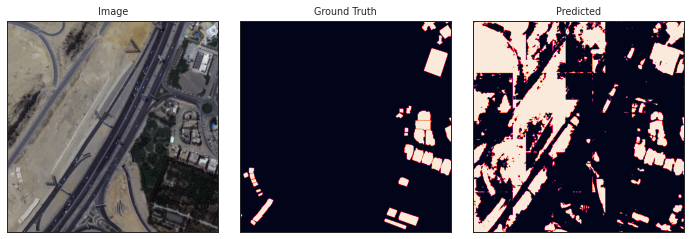

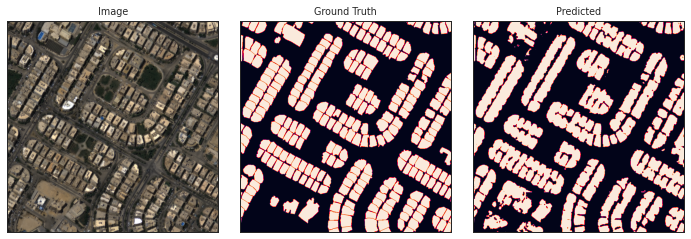

In [224]:
BACKBONE = 'efficientnetb3'

show_inference(model=model_12_1B, first=10, last=15)

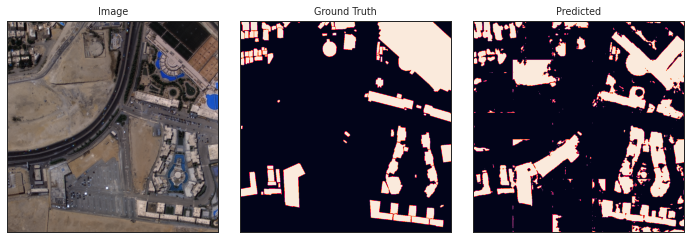

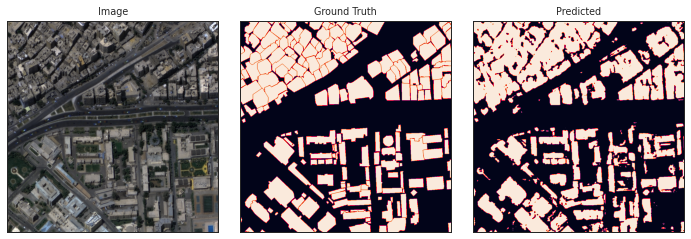

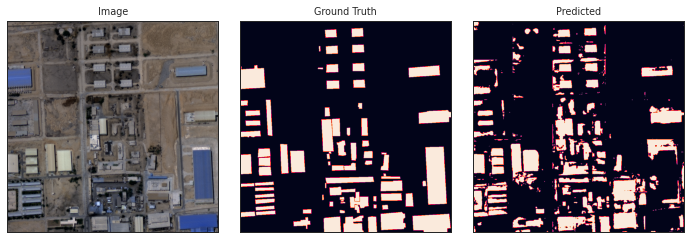

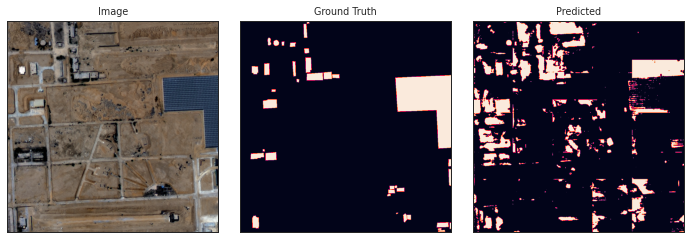

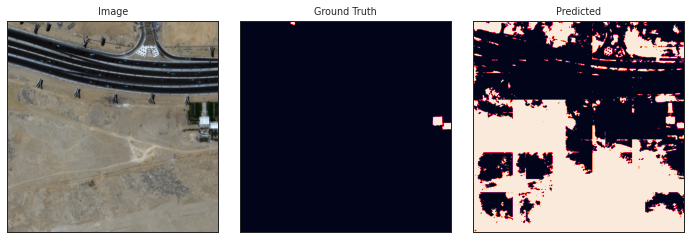

In [226]:
BACKBONE = 'efficientnetb3'

show_inference(model=model_12_1B, first=50, last=55)

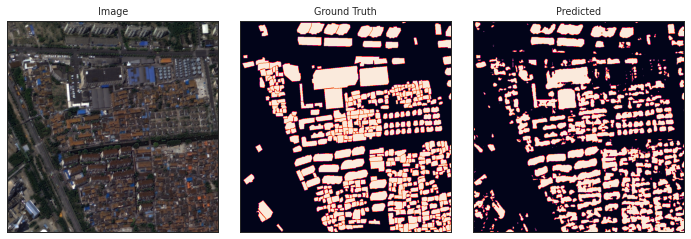

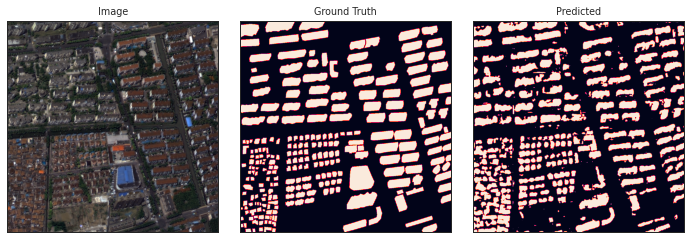

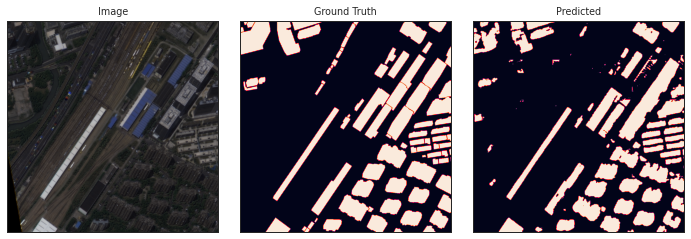

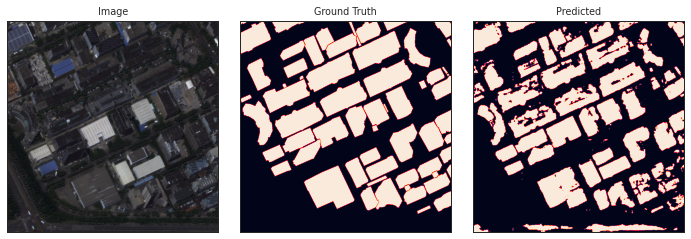

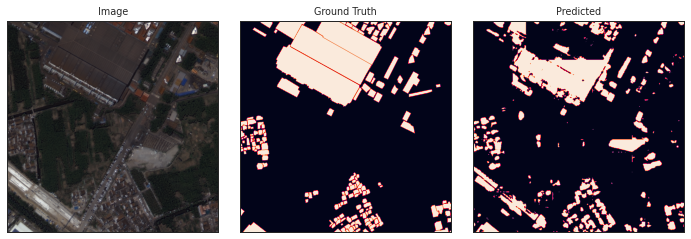

In [222]:
BACKBONE = 'efficientnetb3'

show_inference(model=model_12_1B, first=100, last=105)

## E12-2B

### Fit parameters setting

In [ ]:
lr = 1e-3
BATCH_SIZE = 8      # for PC, 32: for cloud
EPOCHS = 100
CROP_NUM = 25

optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [ ]:
model_12_2B, callbacks = get_model('E12-2B',
                                  optim,
                                  train_datagenerator, 
                                  valid_datagenerator,
                                  SAVE_MODEL_PATH +'/E12_2B.h5',
                                  patience=10)

In [ ]:
start_time = time.time()

history_12_1B = model_12_1B.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

In [ ]:
show_history_plot(history_12_2B.history)

### Evaluation

In [ ]:
model_12_2B.load_weights(SAVE_MODEL_PATH +'/E12_2B.h5)

In [ ]:
preprocess_input = sm.get_preprocessing('efficientnetb3')

test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_CROP_FILTER_IMG_PATH, 
    TEST_CROP_FILTER_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)

val_metrix = model_12_2B.evaluate(valid_datagenerator)
test_metrix = model_12_2B.evaluate(test_datagenerator)

In [ ]:
BACKBONE = 'efficientnetb3'

show_inference(model=model_12_1B, first=50, last=55)